## Self Organizing Map for Mixed Type data

In [ ]:
# //
# //                       _oo0oo_
# //                      o8888888o
# //                      88" . "88
# //                      (| -_- |)
# //                      0\  =  /0
# //                    ___/`---'\___
# //                  .' \\|     |// '.
# //                 / \\|||  :  |||// \
# //                / _||||| -:- |||||- \
# //               |   | \\\  -  /// |   |
# //               | \_|  ''\---/''  |_/ |
# //               \  .-\__  '-'  ___/-. /
# //             ___'. .'  /--.--\  `. .'___
# //          ."" '<  `.___\_<|>_/___.' >' "".
# //         | | :  `- \`.;`\ _ /`;.`/ - ` : | |
# //         \  \ `_.   \_ __\ /__ _/   .-` /  /
# //     =====`-.____`.___ \_____/___.-`___.-'=====
# //                       `=---='


In [1]:
import pandas as pd
import numpy as np
import random
import math
import scipy
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import animation, colors
from matplotlib.colors import LinearSegmentedColormap

# Helper Functions

In [35]:
# random initialization
def rand_weight(x,y,cr,data,seed = 10):

    # x,y - x*y neurons
    # cr - index of cat features start
    # data - input dataframe


    n = data.shape[0]
    p = data.shape[1]

    random.seed(seed)

    l = []
    

    for j in range(0,x):
        ly = []

        for i in range(0,y):
            w = []

            # for numerical attributes, generate random(0,1)
            for k in range(0,cr):

                w.append(random.uniform(0,1))
            # for categorical attributes, generate probability(0,1)
            for t in range(cr,p):
                # unique values of attribute t
                u_set = data.iloc[:,t].unique()

                dic = {}
                for q in u_set:
                    dic[q] = random.uniform(0,1)

                w.append(dic)

            ly.append(w)
            
        l.append(ly)


    
    
    

    return l


# Distance function
def dissimilarity(X, W, cr):

    # X,W - two list with same size

    n = len(X)

    d_num = 0
    d_cat = 0

    for i in range(0,cr):
         d_num += (X[i] - W[i])**2

    for j in range(cr,n):
        d_cat += (1 - W[j][X[j]])**2

    d = d_num + d_cat

    return d




#find the representation of the winner unit chossing highest probability
def cexp(c,cr,n):
    
    c_exp = c[0:cr]

    for i in range(cr,n):
        c_exp.append(max(c[i], key=c[i].get))

    return c_exp



# eucliean distance
def e_distance(x,y):
  return scipy.spatial.distance.euclidean(x,y)



# sigma function
def sigma(s1,s,T):
    sigma = s1*math.exp(-s/T)
    return sigma





# generate intial weight for each neuron
def init_weight(x,y,cr,p,data):

   

    random.seed(1123)

    l = []
    

    for j in range(0,x):
        ly = []

        for i in range(0,y):
            w = []

            # for numerical attributes, generate random(0,1)
            for k in range(0,cr):

                w.append(0)
            # for categorical attributes, generate probability(0,1)
            for t in range(cr,p):
                # unique values of attribute t
                u_set = data.iloc[:,t].unique()

                dic = {}
                for q in u_set:
                    dic[q] = 0

                w.append(dic)

            ly.append(w)
            
        l.append(ly)
    

    return l


## Training SOM

In [456]:
def train_fmsom(x,
                y,
                data,
                y_label,
                cr,
                s1,
                T,
                nei_fun = None,
                iteration=1000,
                seed = 10):

    # x - x*y neurons
    # y - x*y neurons
    # data - input dataframe
    # cr - number of categorcial attributes
    # s1 - initial radius
    # T - contant for sigma function
    # sigma - radius function
    # dis_fun - distance function
    # nei_fun - neighbourhood function
    # iteration - number of iterations
    # init_weight_fun - initial weight function 


    #MSE
    mse = 0


    #result dataframe
    result = data.copy()
    result['winX'] = 'a'#pd.Series()
    result['winY'] = 'b'#pd.Series()



    # P: sample size
    # F: number of attributes
    P, F = np.shape(data)

    # I: number of neurons
    I = x*y

    accumNeighborhood_i = np.zeros((x,y)) 
    numcatWeightUpdates_in_ikc = init_weight(x,y,cr,F,data)
    
    changed = [False]*P

    #intialize 
    weights = rand_weight(x,y,cr,data,seed)


    ##2d som for visuallization####################################################################
    label_data = y_label
    map = np.empty(shape=(x, y), dtype=object)
    for row in range(x):
        for col in range(y):
            map[row][col] = [] # empty list to store the label
    
    label_map = np.zeros(shape=(x, y),dtype=np.int64)
    dis_map = np.zeros(shape=(x, y),dtype=np.int64)
    ################################################################################################



    for t in range(0,iteration):

        #print("current iteration: " + str(t))


        # initialize 2d graph for each iteration
        #som2dt.clear()
        #som2dt = map.copy()
        som2dt = np.empty(shape=(x, y), dtype=object)
        for row in range(x):
            for col in range(y):
                som2dt[row][col] = []


        #cluster assignment
        clusterAssign = np.empty(shape=(x, y), dtype=object)
        for row in range(x):
            for col in range(y):
                clusterAssign[row][col] = []


        # iterating every data point
        for p in range(0,P):

            x_p = data.loc[p]
            #distMat_x_ij = np.zeros((x,y)) # distance from data point p to 

            winX = 1000
            winY = 1000
            win_dis = 1000000000000
            
            #Competitive Process:
            for i in range(0,x):
                for j in range(0,y):
                    # compute distance from x to neuron ij
                    d = dissimilarity(x_p,weights[i][j],cr)
                    
                    if d < win_dis:
                        #changed = True
                        win_dis = d
                        winX = i 
                        winY = j
            
            if winX != result.loc[p,'winX'] or winY != result.loc[p,'winY']:
                
                result.loc[p,'winX'] = winX
                result.loc[p,'winY'] = winY
                changed[p] = True
    
            
            # update winner unit 2d som ####################################################
            som2dt[winX][winY].append(label_data[p]) 
            ################################################################################


            #Update cluster assignment######################################################
            clusterAssign[winX][winY].append(p)
            ################################################################################

            #Cooperative Process:

            #find the representation of the winner unit chossing highest probability
            #win_unit_exp = cexp(weights[winX][winY],1,F)

            sig = sigma(s1,t,T)
            #print("sigma is "+ str(sig))
            for iii in range(0,x):
                for jjj in range(0,y):
                    d_latticce = e_distance([winX,winY],[iii,jjj])
                    
                    # if the latticce inside the radius of the winner neuron
                    if d_latticce < sig:

                        # compute the gaussian neighbourhood function
                        h = math.exp(-(d_latticce**2)/(2*(sig**2)) )

                        # update the total accumulated neighbourhood of the i,j th n
                        accumNeighborhood_i[iii][jjj] += h


                        # update the accumulated neighbourhood for the numerical feature
                        for n in range(0,cr):
                            numcatWeightUpdates_in_ikc[iii][jjj][n] += h*data.iloc[p,n]
                        
                        # update the accumulated neighbourhood for the catgorical feature
                        for k in range(cr,F):
                            numcatWeightUpdates_in_ikc[iii][jjj][k][data.iloc[p,k]] += h
    
        #Adaptive Process
        for ii in range(0,x):
            for jj in range(0,y):
                if accumNeighborhood_i[ii][jj] > 0:
                    
                    #Update Weight for numerical W
                    for n in range(0,cr):
                        weights[ii][jj][n] = numcatWeightUpdates_in_ikc[ii][jj][n] / accumNeighborhood_i[ii][jj]
                    
                    #update Weight for categorical W
                    for k in range(cr,F):
                        for r in data.iloc[:,k].unique():
                            weights[ii][jj][k][r] = numcatWeightUpdates_in_ikc[ii][jj][k][r] / accumNeighborhood_i[ii][jj]

        #print(changed)

        # #Check Convergence
        if (not any(changed) ):
            
            #########################################################################################
            # magority voting: if a neuron 
            for row in range(0,x):
                for col in range(0,y):
                    label_list = som2dt[row][col]
                    if len(label_list)==0:
                        label = -1
                    else:
                        label = max(label_list, key=label_list.count)
                    label_map[row][col] = label
                    dis_map[row][col] = len(label_list)
            ##########################################################################################

                    #MSE
                    assignment_i = clusterAssign[row][col]
                    w_i = weights[row][col]
                    for e in assignment_i:
                        
                        d_ip = dissimilarity(data.loc[e],w_i,cr)
                        mse = mse + abs(d_ip)

            # turn x,y to neuron i
            result["Win_i"] = result["winX"].astype(str) + result["winY"].astype(str)



            #print("current interation is " + str(t))
            return label_map, result, weights, dis_map, mse
        else:
            accumNeighborhood_i = np.zeros((x,y))
            numcatWeightUpdates_in_ikc = init_weight(x,y,cr,F,data)

            changed = [False]*P




In [5]:
# CU and CV value

def cu(df, cr):
    d = df.shape[0]
    n = df.shape[1] - 3
    tol = 0
    neurons = df.iloc[:,-1].unique()

    for c in neurons:
        n_ci = len(df[df.iloc[:, -1] == c])
        ratio = n_ci / d
        df_ci = df[df.iloc[:, -1] == c]
        
        tol1 = 0
        for i in range(cr,n):
            uniV = df.iloc[:, i].unique()
            uniV_n = len(uniV)
            tol2 = 0
            
            for j in range(uniV_n):
                vij = uniV[j]
                pck = len(df_ci[df_ci.iloc[:, i] == vij]) / n_ci
                p = len(df[df.iloc[:, i] == vij]) / d
                tp = pck**2 - p**2
                
                tol2 += tp
            
            tol1 += tol2
        
        tol += tol1 * ratio
    
    return tol


def var(df,cr):
    d = df.shape[0]
    n = df.shape[1] - 3
    tol = 0
    neurons = df.iloc[:,-1].unique()

    for c in neurons:
        toi = 0
        n_ci = len(df[df.iloc[:, -1] == c])
        df_ci = df[df.iloc[:, -1] == c]
        for i in range(0,cr):
            toj = 0
            Ai = df_ci.iloc[:, i]
            avgAi = np.mean(Ai)
            for j in Ai:
                toj += (j-avgAi)**2
            toi += toj
        tol += (1/n_ci)*toi

    return tol


# def var1(df,cr):
#     d = df.shape[0]
#     n = df.shape[1] - 3
#     tol = 0
#     neurons = df.iloc[:,-1].unique()

#     for c in neurons:
#         toi = 0
#         n_ci = len(df[df.iloc[:, -1] == c])
#         df_ci = df[df.iloc[:, -1] == c]
#         for i in range(0,cr):
#             toj = 0
#             Ai = df_ci.iloc[:, i]
#             # avgAi = np.mean(Ai)
#             # for j in Ai:
#             #     toj += (j-avgAi)**2
#             toi += np.var(Ai)
#         tol += (1/n_ci)*toi

#     return tol


def cv(df,cr):

    cv = cu(df,cr)/(1+var(df,cr))

    return cv


## Diagnosis Data

In [368]:
#read diagnosis data
df_diag = pd.read_csv('D:\STATS4T06\Datasets\diagnosis.csv')


scaler = MinMaxScaler()
df_diag['Column1'] = scaler.fit_transform(df_diag[['Column1']])


trainx_diag = df_diag.iloc[:,0:6]

trainy1_diag = df_diag.loc[:,'Column7']
trainy1_diag = trainy1_diag.map({'yes': 1, 'no': 0})

trainy2_diag = df_diag.loc[:,'Column8']
trainy2_diag = trainy2_diag.map({'yes': 1, 'no': 0})



trainx_diag


,Column1,Column2,Column3,Column4,Column5,Column6
0,0.000000,no,yes,no,no,no
1,0.066667,no,no,yes,yes,yes
2,0.066667,no,yes,no,no,no
3,0.083333,no,no,yes,yes,yes
4,0.083333,no,yes,no,no,no
...,...,...,...,...,...,...
115,0.983333,no,yes,yes,no,yes
116,1.000000,no,no,no,no,no
117,1.000000,yes,yes,no,yes,no
118,1.000000,no,yes,yes,no,yes


In [95]:
diag_x = 10
diag_y = 10

diag_map,diag_re,diag_weights,diag_dis,diag_mse = train_fmsom(x=diag_x,y=diag_y,data=trainx_diag,y_label=trainy1_diag ,cr=1,s1=5,T=25,nei_fun = None,iteration=1000,seed = 10)



current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current interation is 43


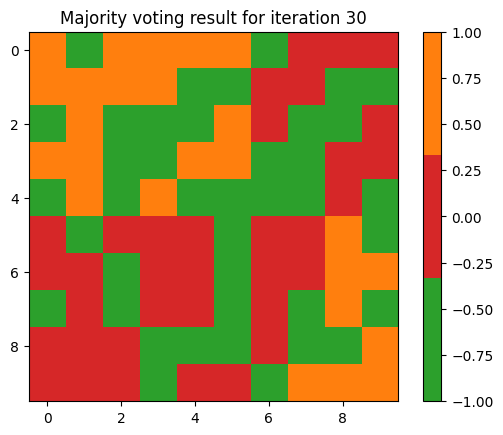

In [182]:
title = ('Majority voting result for iteration ' + str(30))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(diag_map, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

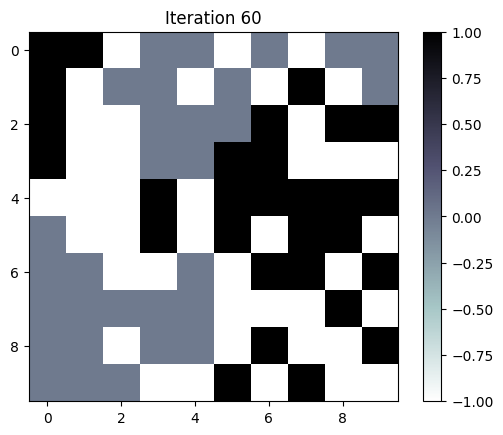

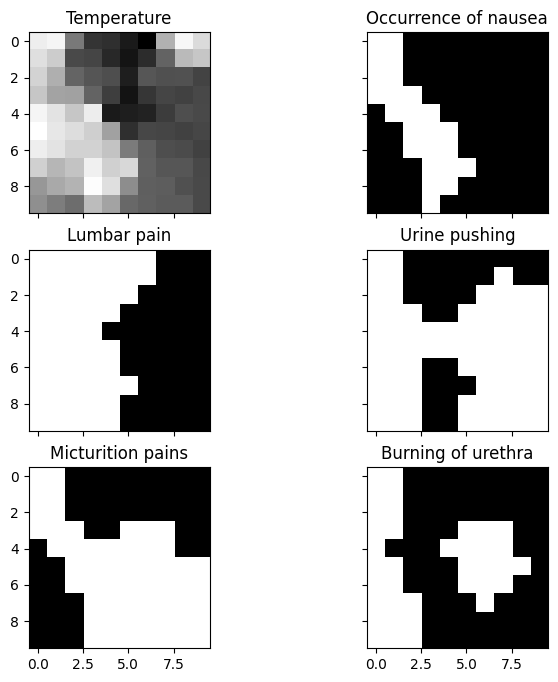

In [8]:
title = ('Iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
#plt.imshow(diag_map, cmap=cmap1)
plt.imshow(diag_map, cmap='bone_r')
plt.colorbar()
plt.title(title)
plt.show()

#Tempture map
temp_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        temp_map[i][j] = diag_weights[i][j][0]

# symptoms1
s1_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][1], key=diag_weights[i][j][1].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s1_map[i][j] = mm

# symptoms2
s2_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][2], key=diag_weights[i][j][2].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s2_map[i][j] = mm

# symptoms3
s3_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][3], key=diag_weights[i][j][3].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s3_map[i][j] = mm

# symptoms4
s4_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][4], key=diag_weights[i][j][4].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s4_map[i][j] = mm

# symptoms5
s5_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][5], key=diag_weights[i][j  ][5].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s5_map[i][j] = mm




# title = ('Iteration ' + str(45))
# cmap = plt.cm.gray
# plt.imshow(temp_map, cmap=cmap)
# plt.colorbar()
# plt.title(title)
# plt.show()

cmap = plt.cm.gray

fig, axs = plt.subplots(3, 2,figsize=(8,8))

axs[0, 0].imshow(temp_map, cmap=cmap)
axs[0, 0].set_title('Temperature')
axs[0, 1].imshow(s1_map, cmap=cmap)
axs[0, 1].set_title('Occurrence of nausea')
axs[1, 0].imshow(s2_map, cmap=cmap)
axs[1, 0].set_title('Lumbar pain')
axs[1, 1].imshow(s3_map, cmap=cmap)
axs[1, 1].set_title('Urine pushing')
axs[2, 0].imshow(s4_map, cmap=cmap)
axs[2, 0].set_title('Micturition pains')
axs[2, 1].imshow(s5_map, cmap=cmap)
axs[2, 1].set_title('Burning of urethra')

for ax in axs.flat:
    ax.label_outer()

## Drug Data

In [6]:
df_drug = pd.read_csv('D:\STATS4T06\Datasets\drug200.csv')

df_drug = df_drug.iloc[:,[0,4,1,2,3,5]]

scaler = MinMaxScaler()
df_drug['Age'] = scaler.fit_transform(df_drug[['Age']])
df_drug['Na_to_K'] = scaler.fit_transform(df_drug[['Na_to_K']])


trainx_drug = df_drug.iloc[:,0:5]

trainy_drug = df_drug.iloc[:,5]
trainy_drug = trainy_drug.map({'DrugY': 0, 'drugC': 1,'drugX':2,'drugA':3,'drugB':4})


df_drug


,Age,Na_to_K,Sex,BP,Cholesterol,Drug
0,0.135593,0.596848,F,HIGH,HIGH,DrugY
1,0.542373,0.213397,M,LOW,HIGH,drugC
2,0.542373,0.120239,M,LOW,HIGH,drugC
3,0.220339,0.047814,F,NORMAL,HIGH,drugX
4,0.779661,0.368191,F,LOW,HIGH,DrugY
...,...,...,...,...,...,...
195,0.694915,0.165676,F,LOW,HIGH,drugC
196,0.016949,0.179405,M,LOW,HIGH,drugC
197,0.627119,0.113359,M,NORMAL,HIGH,drugX
198,0.135593,0.242385,M,NORMAL,NORMAL,drugX


In [41]:
drug_x = 20
drug_y = 20

drug_map,drug_re,drug_weights,drug_dis  = train_fmsom(x=drug_x,y=drug_y,data=trainx_drug,y_label=trainy_drug ,cr=2,s1=10,T=25,nei_fun = None,iteration=1000,seed = 10)

drug_dis

current interation is 59


array([[ 97,  41,  93,  33,  61,  36,  50,  53, 102,  49,  91,  32,  27,
         19,  64,  56, 111,  43,  32, 106],
       [ 43,  32,   2,  15,  13,  32,   0,  44,  36,  20,   6,  40,   5,
         16,   6,  40,  29,  11,  19,  18],
       [ 47,  30,  21,  19,  18,   7,  20,  26,  39,  15,  32,  13,  24,
          5,  20,  13,  32,  13,  13,  10],
       [ 40,  24,  39,  18,  45,  11,  24,  11,  17,  20,  16,  16,  11,
         14,  12,  18,  12,   7,   8,  32],
       [ 49,   4,  27,  11,   4,  12,  27,  13,  20,  30,  42,   3,  19,
          9,  15,   7,   2,  21,  10,  98],
       [ 65,  19,   4,   5,  23,  48,  30,  10,  15,   0,   0,  12,  12,
         40,  17,   5,  10,  25,  35,  75],
       [173,  20,  18,  60,  22,  17,   7,  25,   7,   9,  35,  13,  62,
         41,  33,   5,   6,  16,  33,  66],
       [ 42,  27,  24,  31,  20,  18,  20,   5,  28,  65,  54,  59,  18,
         37,  20,   8,  24,  30,  23,  36],
       [  8,  29,  18,  39,  28,  25,  20,   5,  70,  67,  30,  

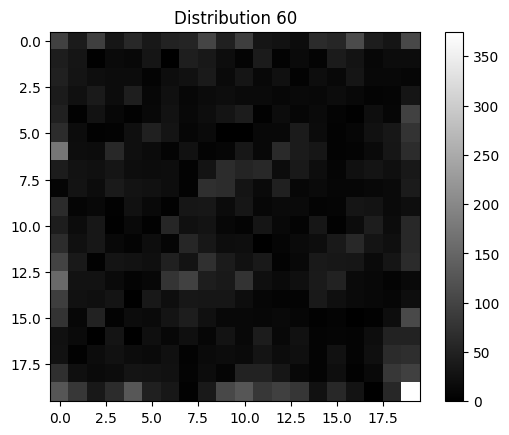

In [42]:
title = ('Distribution ' + str(60))
cmap = plt.cm.gray
plt.imshow(drug_dis, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

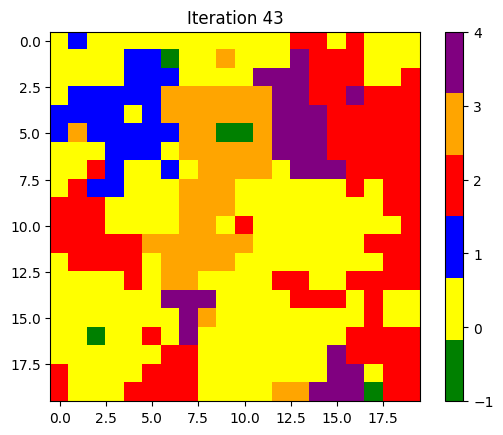

In [243]:
title = ('Iteration ' + str(43))
cmap = colors.ListedColormap(['green','yellow', 'blue','red', 'orange','purple'])
plt.imshow(drug_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

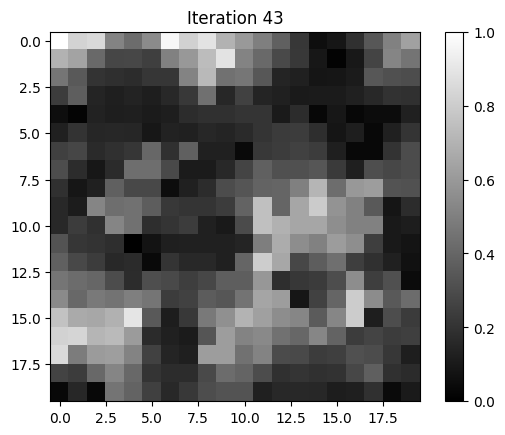

In [244]:
#Na_to_k map
na_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        na_map[i][j] = drug_weights[i][j][1]
cmap_age = plt.cm.gray
plt.imshow(na_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

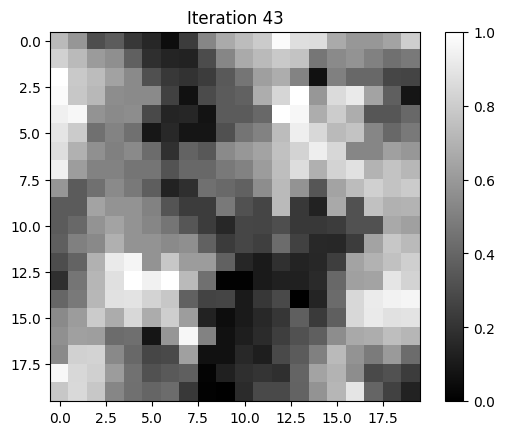

In [245]:
#age map
age_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        age_map[i][j] = drug_weights[i][j][0]
cmap_age = plt.cm.gray
plt.imshow(age_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

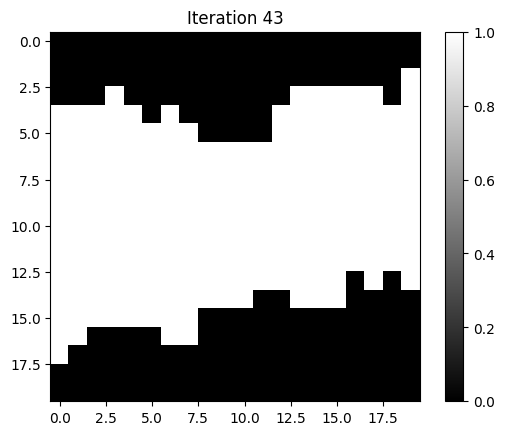

In [246]:
# gender map
g_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        m = max(drug_weights[i][j][2], key=drug_weights[i][j][2].get)
        if m == 'M':
            mm = 1
        elif m == 'F':
            mm = 0
        g_map[i][j] = mm

plt.imshow(g_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

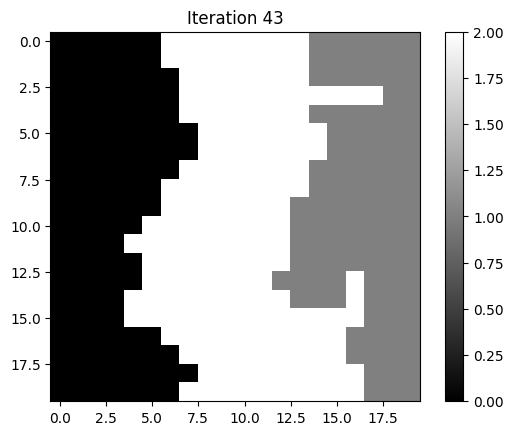

In [247]:
# BP map
bp_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        m = max(drug_weights[i][j][3], key=drug_weights[i][j][3].get)
        if m == 'HIGH':
            mm = 2
        elif m == 'NORMAL':
            mm = 1
        elif m == 'LOW':
            mm = 0
        bp_map[i][j] = mm

plt.imshow(bp_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

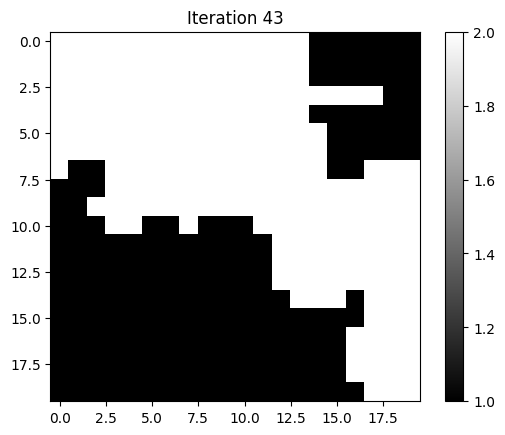

In [252]:
# Cholesterol	 map
cho_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        m = max(drug_weights[i][j][4], key=drug_weights[i][j][4].get)
        if m == 'HIGH':
            mm = 2
        elif m == 'NORMAL':
            mm = 1
        elif m == 'LOW':
            mm = 0
        cho_map[i][j] = mm

plt.imshow(cho_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

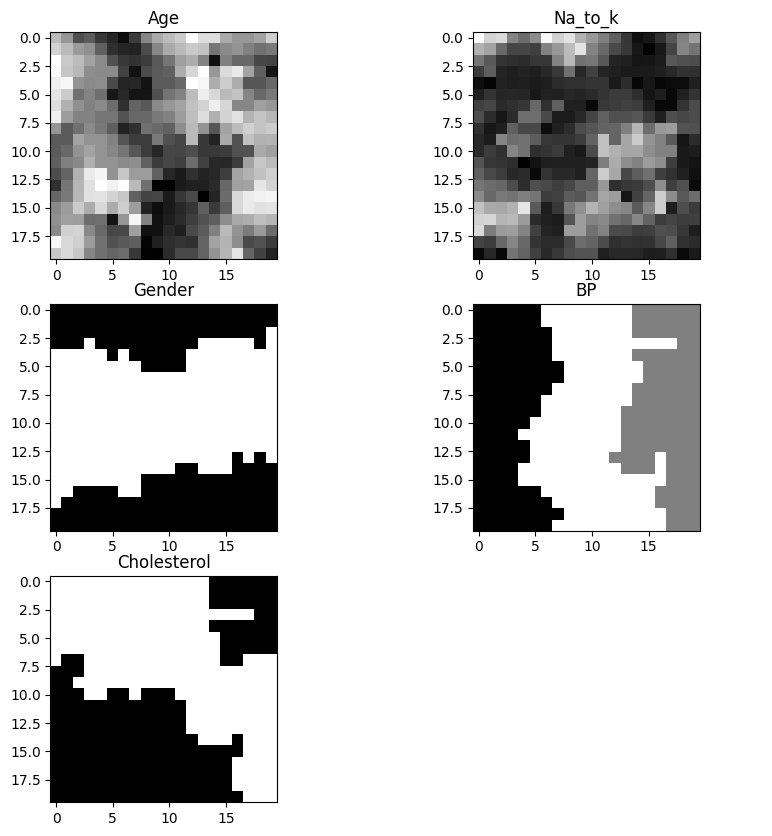

In [256]:
fig1, axs1 = plt.subplots(3, 2,figsize=(10,10))

axs1[0, 0].imshow(age_map, cmap=cmap_age)
axs1[0, 0].set_title('Age')
axs1[0, 1].imshow(na_map, cmap=cmap_age)
axs1[0, 1].set_title('Na_to_k')
axs1[1, 0].imshow(g_map, cmap=cmap_age)
axs1[1, 0].set_title('Gender')
axs1[1, 1].imshow(bp_map, cmap=cmap_age)
axs1[1, 1].set_title('BP')
axs1[2, 0].imshow(cho_map, cmap=cmap_age)
axs1[2, 0].set_title('Cholesterol')
axs1[-1, -1].axis('off')

for ax in axs.flat:
    ax.label_outer()

## Credit Approval Data

In [12]:

df_ca = pd.read_csv("D:\\STATS4T06\\Datasets\\crx.data", delimiter=",",header=None)

print(df_ca)
df_ca.columns = ['a0', 'a1', 'a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15']

df_ca = df_ca.replace("?", np.nan)
df_ca = df_ca.dropna()



df_ca = df_ca.iloc[:,[1,2,7,10,13,14,3,4,5,6,8,9,11,12,15]]
df_ca = df_ca.reset_index()

df_ca['a1'] = df_ca['a1'].astype(float)
df_ca['a2'] = df_ca['a2'].astype(float)
df_ca['a7'] = df_ca['a7'].astype(float)
df_ca['a10'] = df_ca['a10'].astype(float)
df_ca['a13'] = df_ca['a13'].astype(float)
df_ca['a14'] = df_ca['a14'].astype(float)

scaler = MinMaxScaler()
df_ca['a1'] = scaler.fit_transform(df_ca[['a1']])
df_ca['a2'] = scaler.fit_transform(df_ca[['a2']])
df_ca['a7'] = scaler.fit_transform(df_ca[['a7']])
df_ca['a10'] = scaler.fit_transform(df_ca[['a10']])
df_ca['a13'] = scaler.fit_transform(df_ca[['a13']])
df_ca['a14'] = scaler.fit_transform(df_ca[['a14']])



trainx_ca = df_ca.iloc[:,1:14]


trainy_ca = df_ca.iloc[:,15].map({'+': 1, '-': 0})

trainx_ca



    0      1       2  3  4   5   6     7  8  9   10 11 12     13   14 15
0    b  30.83   0.000  u  g   w   v  1.25  t  t   1  f  g  00202    0  +
1    a  58.67   4.460  u  g   q   h  3.04  t  t   6  f  g  00043  560  +
2    a  24.50   0.500  u  g   q   h  1.50  t  f   0  f  g  00280  824  +
3    b  27.83   1.540  u  g   w   v  3.75  t  t   5  t  g  00100    3  +
4    b  20.17   5.625  u  g   w   v  1.71  t  f   0  f  s  00120    0  +
..  ..    ...     ... .. ..  ..  ..   ... .. ..  .. .. ..    ...  ... ..
685  b  21.08  10.085  y  p   e   h  1.25  f  f   0  f  g  00260    0  -
686  a  22.67   0.750  u  g   c   v  2.00  f  t   2  t  g  00200  394  -
687  a  25.25  13.500  y  p  ff  ff  2.00  f  t   1  t  g  00200    1  -
688  b  17.92   0.205  u  g  aa   v  0.04  f  f   0  f  g  00280  750  -
689  b  35.00   3.375  u  g   c   h  8.29  f  f   0  t  g  00000    0  -

[690 rows x 16 columns]


,a1,a2,a7,a10,a13,a14,a3,a4,a5,a6,a8,a9,a11
0,0.271111,0.000000,0.043860,0.014925,0.1010,0.00000,u,g,w,v,t,t,f
1,0.713016,0.159286,0.106667,0.089552,0.0215,0.00560,u,g,q,h,t,t,f
2,0.170635,0.017857,0.052632,0.000000,0.1400,0.00824,u,g,q,h,t,f,f
3,0.223492,0.055000,0.131579,0.074627,0.0500,0.00003,u,g,w,v,t,t,t
4,0.101905,0.200893,0.060000,0.000000,0.0600,0.00000,u,g,w,v,t,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,0.116349,0.360179,0.043860,0.000000,0.1300,0.00000,y,p,e,h,f,f,f
649,0.141587,0.026786,0.070175,0.029851,0.1000,0.00394,u,g,c,v,f,t,t
650,0.182540,0.482143,0.070175,0.014925,0.1000,0.00001,y,p,ff,ff,f,t,t
651,0.066190,0.007321,0.001404,0.000000,0.1400,0.00750,u,g,aa,v,f,f,f


In [321]:
ca_x = 12
ca_y = 12

# 12*12 s1 = 5 T = 10  mse:301.9397  cv: 0.470903 图一般
# 12*12 s1 = 5 T = 25  mse:301.4184  cv: 0.470618 图一般
# 12*12 s1 = 5 T = 50  mse:333.1652  cv: 0.49916  图一般好一点？
# 12*12 s1 = 6 T = 10  mse:262.7263  cv: 0.47433  图一般不是很好
# 12*12 s1 = 6 T = 25  mse:283.1454  cv: 0.47207  图一般不是很好 
# 12*12 s1 = 6 T = 50  mse:280.403   cv: 0.45935  图一般不是很好
# 12*12 s1 = 7 T = 10  mse:255.022   cv: 0.4233   图还行
# 12*12 s1 = 7 T = 25  mse:281.8884   cv: 0.48146   图一般
# 12*12 s1 = 7 T = 50  mse:289.9499   cv: 0.47667   图还行右上角有一点
ca_map1,ca_re1,ca_weights1,ca_dis1,ca_mse1  = train_fmsom(x=ca_x,y=ca_y,data=trainx_ca,y_label=trainy_ca ,cr=6,s1=7,T=50
                                                          ,nei_fun = None,iteration=1000,seed = 1112312)

ca_mse1

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current iteration: 44
current iteration: 4

289.94994343340676

In [322]:
cv(ca_re1,6)

0.4766700736629185

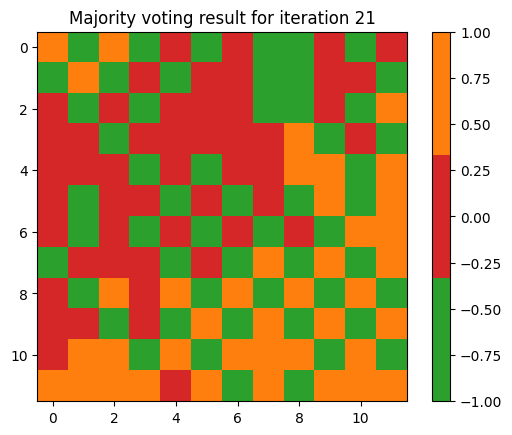

In [323]:
title = ('Majority voting result for iteration ' + str(21))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(ca_map1, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

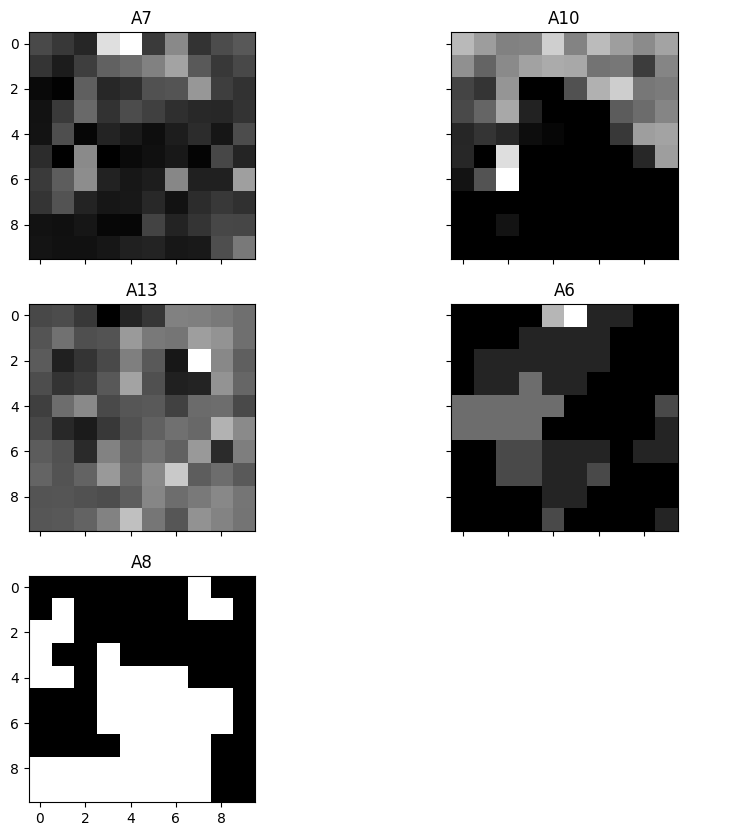

In [18]:
a7_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a7_map[i][j] = ca_weights1[i][j][2]

a10_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a10_map[i][j] = ca_weights1[i][j][3]

a13_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a13_map[i][j] = ca_weights1[i][j][4]


a6_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][9], key=ca_weights1[i][j][9].get)
        if m == 'v':
            mm = 0
        elif m == 'h':
            mm = 1
        elif m == 'bb':
            mm = 2
        elif m == 'ff':
            mm = 3
        elif m == 'j':
            mm = 4
        elif m == 'z':
            mm = 5
        elif m == 'o':
            mm = 6
        elif m == 'dd':
            mm = 7
        elif m == 'n':
            mm = 8
        a6_map[i][j] = mm



a8_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][10], key=ca_weights1[i][j][10].get)
        if m == 't':
            mm = 0
        elif m == 'f':
            mm = 1
        
        a8_map[i][j] = mm


cmap_gray = plt.cm.gray

fig, axs = plt.subplots(3, 2,figsize=(10,10))

axs[0, 0].imshow(a7_map, cmap=cmap_gray)
axs[0, 0].set_title('A7')
axs[0, 1].imshow(a10_map, cmap=cmap_gray)
axs[0, 1].set_title('A10')
axs[1, 0].imshow(a13_map, cmap=cmap_gray)
axs[1, 0].set_title('A13')
axs[1, 1].imshow(a6_map, cmap=cmap_gray)
axs[1, 1].set_title('A6')
axs[2, 0].imshow(a8_map, cmap=cmap_gray)
axs[2, 0].set_title('A8')
axs[-1, -1].axis('off')



for ax in axs.flat:
    ax.label_outer()


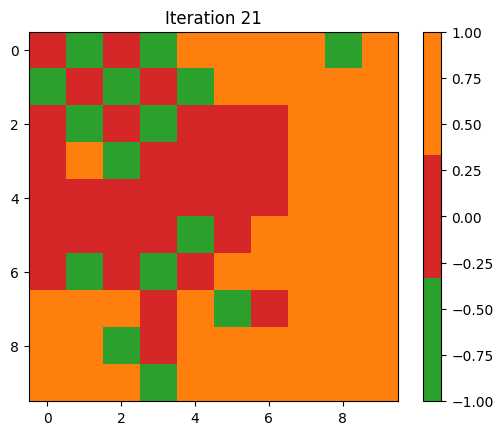

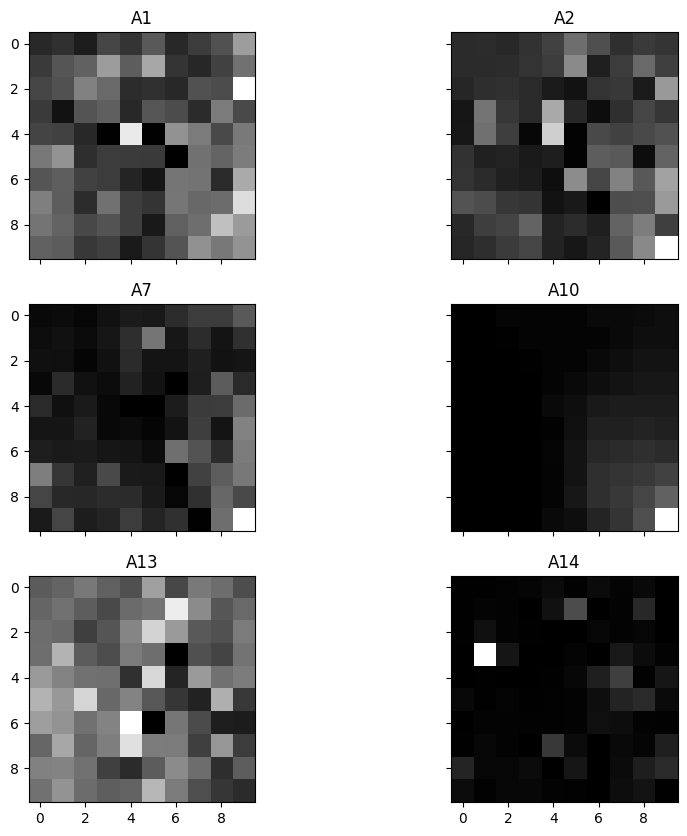

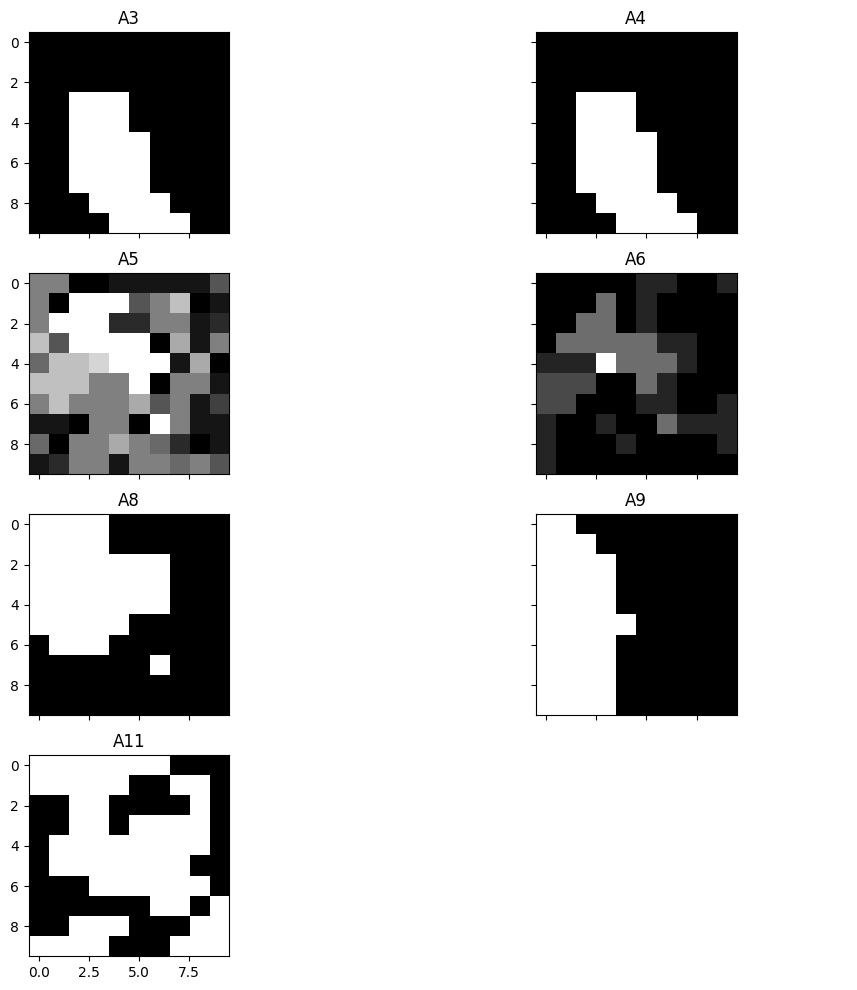

In [292]:
title = ('Iteration ' + str(21))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(ca_map1, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

# a1	a2	a7	a10	a13	a14	a3	a4	a5	a6	a8	a9	a11
#a1 map
a1_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a1_map[i][j] = ca_weights1[i][j][0]


#a2 map
a2_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a2_map[i][j] = ca_weights1[i][j][1]


#a2 map
a7_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a7_map[i][j] = ca_weights1[i][j][2]

#a2 map
a10_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a10_map[i][j] = ca_weights1[i][j][3]


#a2 map
a13_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a13_map[i][j] = ca_weights1[i][j][4]


#a2 map
a14_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        a14_map[i][j] = ca_weights1[i][j][5]


## a1	a2	a7	a10	a13	a14	a3	a4	a5	a6	a8	a9	a11

#################################################################################

# a3
a3_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][6], key=ca_weights1[i][j][6].get)
        if m == 'u':
            mm = 0
        elif m == 'y':
            mm = 1
        elif m == 'l':
            mm = 2
        a3_map[i][j] = mm

# a4
a4_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][7], key=ca_weights1[i][j][7].get)
        if m == 'g':
            mm = 0
        elif m == 'p':
            mm = 1
        elif m == 'gg':
            mm = 2
        a4_map[i][j] = mm


# a5  'w' 'q' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j'
a5_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][8], key=ca_weights1[i][j][8].get)
        if m == 'w':
            mm = 0
        elif m == 'q':
            mm = 1
        elif m == 'm':
            mm = 2
        elif m == 'r':
            mm = 3
        elif m == 'cc':
            mm = 4
        elif m == 'k':
            mm = 5
        elif m == 'c':
            mm = 6
        elif m == 'd':
            mm = 7
        elif m == 'x':
            mm = 8
        elif m == 'i':
            mm = 9
        elif m == 'e':
            mm = 10
        elif m == 'aa':
            mm = 11
        elif m == 'ff':
            mm = 12
        elif m == 'j':
            mm = 13
        a5_map[i][j] = mm

# a6  'v' 'h' 'bb' 'ff' 'j' 'z' 'o' 'dd' 'n'
a6_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][9], key=ca_weights1[i][j][9].get)
        if m == 'v':
            mm = 0
        elif m == 'h':
            mm = 1
        elif m == 'bb':
            mm = 2
        elif m == 'ff':
            mm = 3
        elif m == 'j':
            mm = 4
        elif m == 'z':
            mm = 5
        elif m == 'o':
            mm = 6
        elif m == 'dd':
            mm = 7
        elif m == 'n':
            mm = 8
        a6_map[i][j] = mm



a8_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][10], key=ca_weights1[i][j][10].get)
        if m == 't':
            mm = 0
        elif m == 'f':
            mm = 1
        
        a8_map[i][j] = mm



a9_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][11], key=ca_weights1[i][j][11].get)
        if m == 't':
            mm = 0
        elif m == 'f':
            mm = 1
        
        a9_map[i][j] = mm



a11_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][12], key=ca_weights1[i][j][12].get)
        if m == 't':
            mm = 0
        elif m == 'f':
            mm = 1
        
        a11_map[i][j] = mm









# a1	a2	a7	a10	a13	a14	a3	a4	a5	a6	a8	a9	a11


cmap_gray = plt.cm.gray

fig, axs = plt.subplots(3, 2,figsize=(10,10))

axs[0, 0].imshow(a1_map, cmap=cmap_gray)
axs[0, 0].set_title('A1')
axs[0, 1].imshow(a2_map, cmap=cmap_gray)
axs[0, 1].set_title('A2')
axs[1, 0].imshow(a7_map, cmap=cmap_gray)
axs[1, 0].set_title('A7')
axs[1, 1].imshow(a10_map, cmap=cmap_gray)
axs[1, 1].set_title('A10')
axs[2, 0].imshow(a13_map, cmap=cmap_gray)
axs[2, 0].set_title('A13')
axs[2, 1].imshow(a14_map, cmap=cmap_gray)
axs[2, 1].set_title('A14')



for ax in axs.flat:
    ax.label_outer()




# cat
cmap_gray = plt.cm.gray

fig, axs = plt.subplots(4, 2,figsize=(12,12))

axs[0, 0].imshow(a3_map, cmap=cmap_gray)
axs[0, 0].set_title('A3')
axs[0, 1].imshow(a4_map, cmap=cmap_gray)
axs[0, 1].set_title('A4')
axs[1, 0].imshow(a5_map, cmap=cmap_gray)
axs[1, 0].set_title('A5')
axs[1, 1].imshow(a6_map, cmap=cmap_gray)
axs[1, 1].set_title('A6')
axs[2, 0].imshow(a8_map, cmap=cmap_gray)
axs[2, 0].set_title('A8')
axs[2, 1].imshow(a9_map, cmap=cmap_gray)
axs[2, 1].set_title('A9')
axs[3, 0].imshow(a11_map, cmap=cmap_gray)
axs[3, 0].set_title('A11')

axs[-1, -1].axis('off')

for ax in axs.flat:
    ax.label_outer()




['g' 'p' 'gg']


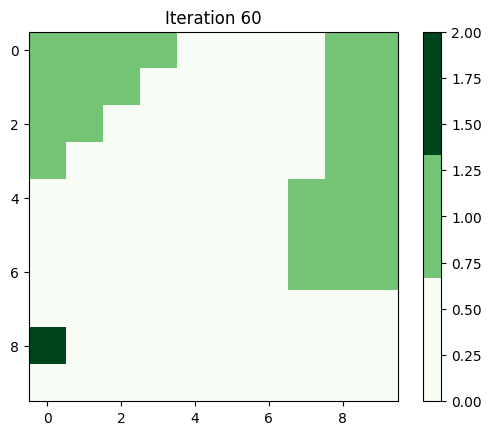

In [47]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt


#cmap_20 = colors.ListedColormap(["red", "orange", "gold", "limegreen", "#550011", "purple", "seagreen"])


cmap_20 = plt.cm.get_cmap('Greens', 3)

# a3	a4	a5	a6	a8	a9	a10	a11	a12
print(df_ca.a4.unique())


# a6
a6_map =np.zeros(shape=(ca_x, ca_y), dtype= float)
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][5], key=ca_weights1[i][j][5].get)
        if m == 'u':
            mm = 0
        elif m == 'y':
            mm = 1
        elif m == 'l':
            mm = 2

        a6_map[i][j] = mm


# a7
a7_map =np.zeros(shape=(ca_x, ca_y), dtype= float)
for i in range(0,ca_x):
    for j in range(0,ca_y):
        m = max(ca_weights1[i][j][6], key=ca_weights1[i][j][6].get)
        if m == 'g':
            mm = 0
        elif m == 'p':
            mm = 1
        elif m == 'gg':
            mm = 2

        a7_map[i][j] = mm


plt.imshow(a6_map, cmap=cmap_20)
plt.colorbar()
plt.title(title)
plt.show()




## South Afriaca Heart Diease


In [51]:

df_sa = pd.read_csv("D:\\STATS4T06\\Datasets\\sa_heart.csv")



df_sa


trainx_sa = df_sa.iloc[:,[1,2,3,4,6,7,8,9,5]]
trainy_sa = df_sa.Class

trainx_sa
# df_ca = df_ca.reset_index()

# df_ca['a1'] = df_ca['a1'].astype(float)
# df_ca['a2'] = df_ca['a2'].astype(float)
# df_ca['a7'] = df_ca['a7'].astype(float)
# df_ca['a13'] = df_ca['a13'].astype(float)
# df_ca['a14'] = df_ca['a14'].astype(float)

# scaler = MinMaxScaler()
# df_ca['a1'] = scaler.fit_transform(df_ca[['a1']])
# df_ca['a2'] = scaler.fit_transform(df_ca[['a2']])
# df_ca['a7'] = scaler.fit_transform(df_ca[['a7']])
# df_ca['a13'] = scaler.fit_transform(df_ca[['a13']])
# df_ca['a14'] = scaler.fit_transform(df_ca[['a14']])



# trainx_ca = df_ca.iloc[:,1:14]


# trainy_ca = df_ca.iloc[:,15].map({'+': 1, '-': 0})


# df_ca

,V1,V2,V3,V4,V6,V7,V8,V9,V5
0,160,12.00,5.73,23.11,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,55,28.87,2.06,63,2
2,118,0.08,3.48,32.28,52,29.14,3.81,46,1
3,170,7.50,6.41,38.03,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,31.72,64,28.45,0.00,58,2
458,182,4.20,4.41,32.10,52,28.61,18.72,52,2
459,108,3.00,1.59,15.23,40,20.09,26.64,55,2
460,118,5.40,11.61,30.79,64,27.35,23.97,40,2


In [182]:
sa_x = 10
sa_y = 10

sa_map,sa_re,sa_weights,sa_dis  = train_fmsom(x=sa_x,y=sa_y,data=trainx_sa,y_label=trainy_sa ,cr=8,s1=5,T=20,nei_fun = None,iteration=1000,seed = 10)

sa_dis

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current interation is 40


array([[ 5,  3,  6,  7,  2,  5,  1,  8, 11,  7],
       [ 3,  5,  4,  4,  6,  5,  5,  4,  7,  9],
       [ 8,  5,  6,  6,  8,  2,  3,  4, 10,  4],
       [ 4,  3,  3,  6,  2,  4,  5, 10,  3,  5],
       [ 2,  5,  3,  4,  2,  7,  3,  7, 10,  7],
       [ 5,  4,  2,  3,  4,  3,  5,  7,  5,  5],
       [ 4,  6,  2,  5,  4,  7,  6,  2,  5,  5],
       [ 4,  5,  5,  3,  5,  4,  5,  7,  3,  3],
       [ 4,  3,  2,  6,  4,  4,  2,  2,  3,  6],
       [ 4,  4,  4,  3,  1,  4,  3,  5,  2,  5]], dtype=int64)

In [168]:
sa_map

array([[ 2,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1],
       [ 2,  1,  1,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  2,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  2,  1,  2,  1,  1,  2,  2,  2,  2,  1,  1,  2,  1,  1],
       [ 1,  1,  2, -1,  1,  2,  2,  2,  1,  1,  2,  1,  1,  1,  1],
       [ 2,  1,  1,  2,  1,  2,  1,  1,  2,  2,  2, -1,  1,  2,  1],
       [ 2,  2,  1,  1,  2, -1,  2,  1,  2,  2,  1,  2,  2,  1,  1],
       [ 1,  2,  2,  1,  1,  1,  1,  2, -1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  2,  1,  1,  2,  2,  2,  1,  2,  2,  1,  1,  1,  2],
       [ 1,  1, -1,  2,  2,  1,  2,  2, -1,  2,  1,  1,  1,  1,  1],
       [ 2,  1,  1,  1,  2,  2,  1,  1,  2,  2,  2,  1,  2,  1,  1],
       [ 2,  2,  1,  2,  1,  1,  2,  2, -1,  2,  1,  2,  1,  2,  2],
       [ 1,  1,  2,  1,  2,  2,  1

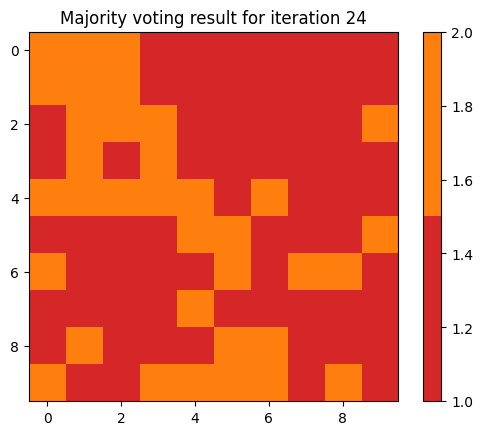

In [183]:
title = ('Majority voting result for iteration ' + str(24))
cmap1 = colors.ListedColormap([ 'tab:red', 'tab:orange'])
plt.imshow(sa_map, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

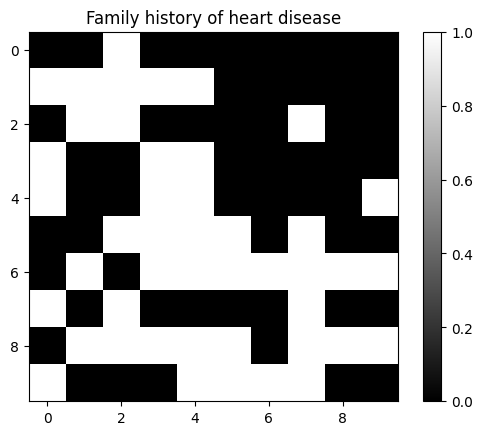

In [190]:
fh_map =np.zeros(shape=(sa_x, sa_y), dtype= float)
for i in range(0,sa_x):
    for j in range(0,sa_y):
        m = max(sa_weights[i][j][8], key=sa_weights[i][j][8].get)
        if m == 2:
            mm = 0
        elif m == 1:
            mm = 1
        

        fh_map[i][j] = mm

title = ('Family history of heart disease')
cmap_gray = plt.cm.gray
cmap1 = colors.ListedColormap([ 'tab:red', 'tab:orange'])
plt.imshow(fh_map, cmap=cmap_gray)
plt.colorbar()
plt.title(title)
plt.show()

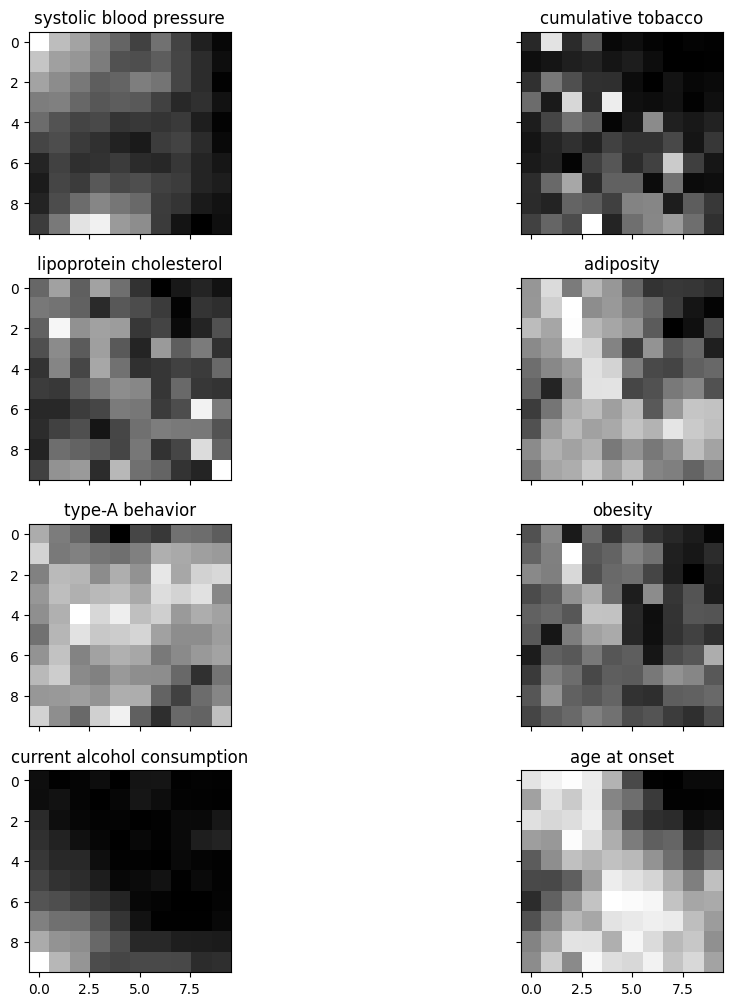

In [185]:


#a1 map
sa1_map = np.zeros(shape=(sa_x, sa_y))
for i in range(0,sa_x):
    for j in range(0,sa_y):
        sa1_map[i][j] = sa_weights[i][j][0]


#a2 map
sa2_map = np.zeros(shape=(sa_x, sa_y))
for i in range(0,sa_x):
    for j in range(0,sa_y):
        sa2_map[i][j] = sa_weights[i][j][1]


#a2 map
sa3_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        sa3_map[i][j] = sa_weights[i][j][2]


#a2 map
sa4_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        sa4_map[i][j] = sa_weights[i][j][3]


#a2 map
sa5_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        sa5_map[i][j] = sa_weights[i][j][4]


sa6_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        sa6_map[i][j] = sa_weights[i][j][5]

sa7_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        sa7_map[i][j] = sa_weights[i][j][6]

sa8_map = np.zeros(shape=(ca_x, ca_y))
for i in range(0,ca_x):
    for j in range(0,ca_y):
        sa8_map[i][j] = sa_weights[i][j][7]




cmap_gray = plt.cm.gray

fig_sa, axs_sa = plt.subplots(4, 2,figsize=(10,10))
fig_sa.tight_layout()

axs_sa[0, 0].imshow(sa1_map, cmap=cmap_gray)
axs_sa[0, 0].set_title('systolic blood pressure')
axs_sa[0, 1].imshow(sa2_map, cmap=cmap_gray)
axs_sa[0, 1].set_title('cumulative tobacco')
axs_sa[1, 0].imshow(sa3_map, cmap=cmap_gray)
axs_sa[1, 0].set_title('lipoprotein cholesterol')
axs_sa[1, 1].imshow(sa4_map, cmap=cmap_gray)
axs_sa[1, 1].set_title('adiposity')
axs_sa[2, 0].imshow(sa5_map, cmap=cmap_gray)
axs_sa[2, 0].set_title('type-A behavior')
axs_sa[2, 1].imshow(sa6_map, cmap=cmap_gray)
axs_sa[2, 1].set_title('obesity')
axs_sa[3, 0].imshow(sa7_map, cmap=cmap_gray)
axs_sa[3, 0].set_title('current alcohol consumption')
axs_sa[3, 1].imshow(sa8_map, cmap=cmap_gray)
axs_sa[3, 1].set_title('age at onset')



for ax in axs_sa.flat:
    ax.label_outer()


## Irish

In [141]:
df_irish = pd.read_csv('D:\\STATS4T06\\Datasets\\irish.csv')

trainx_irish = df_irish.iloc[:,1:6]

scaler = MinMaxScaler()
trainx_irish['DVRT'] = scaler.fit_transform(trainx_irish[['DVRT']])
trainx_irish['Prestige_score'] = scaler.fit_transform(trainx_irish[['Prestige_score']])



trainy_irish = df_irish.iloc[:,6]

trainy_irish
trainy_irish = trainy_irish.map({'taken': 1, 'not_taken': 0})


trainx_irish.Type_school.unique()

#scaler.fit_transform(trainx_irish[['DVRT']])
trainx_irish

,DVRT,Prestige_score,Sex,Educational_level,Type_school
0,0.640000,0.175439,male,Junior_cycle_incomplete-secondary_school,secondary
1,0.480000,0.175439,male,Primary_terminal_leaver,primary_terminal_leaver
2,0.600000,0.894737,male,Senior_cycle_terminal_leaver-secondary_school,secondary
3,0.746667,0.684211,male,Junior_cycle_terminal_leaver-secondary_school,secondary
4,0.226667,0.000000,male,Junior_cycle_terminal_leaver-vocational_school,vocational
...,...,...,...,...,...
463,0.880000,0.210526,male,Senior_cycle_terminal_leaver-secondary_school,secondary
464,0.960000,0.771930,male,3rd_level_complete,secondary
465,0.946667,0.000000,male,3rd_level_complete,secondary
466,0.893333,0.333333,male,3rd_level_complete,secondary


In [279]:
irish_x = 15
irish_y = 15

#7, 25
#7, 10
irish_map,irish_re,irish_weights,irish_dis,irish_mse  = train_fmsom(x=irish_x,y=irish_y,data=trainx_irish,y_label=trainy_irish ,cr=2,s1=7,T=50,nei_fun = None,iteration=1000,seed = 10)

irish_mse

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current iteration: 44
current iteration: 4

4.419023300746995

In [277]:
cv(irish_re,2)

0.8823152485041877

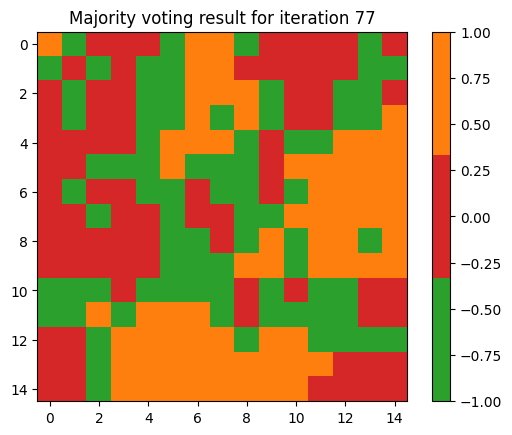

In [278]:
title = ('Majority voting result for iteration ' + str(77))
cmap1 = colors.ListedColormap([ 'tab:green','tab:red', 'tab:orange'])
plt.imshow(irish_map, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

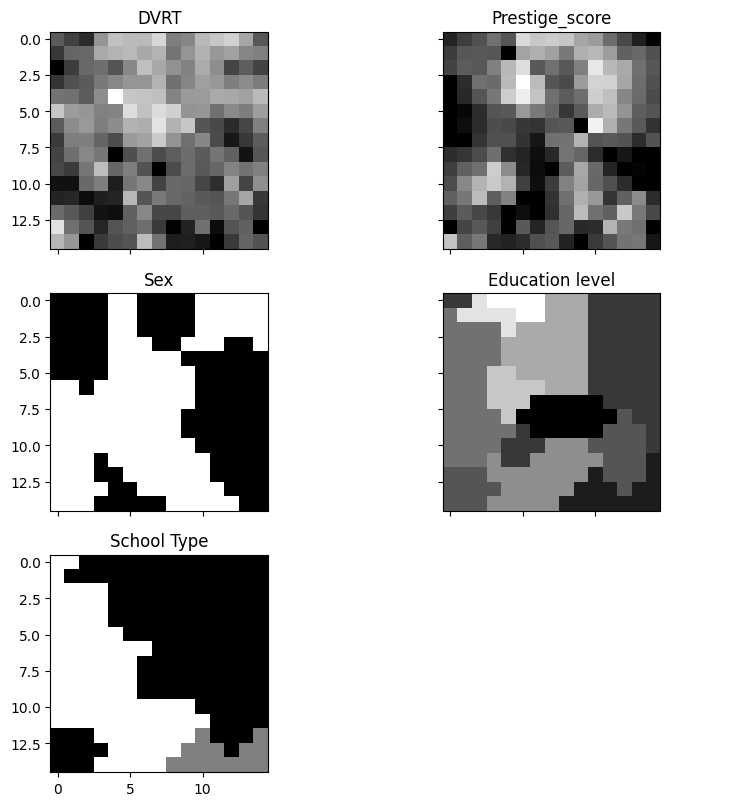

In [272]:
#a1 map
irish1_map = np.zeros(shape=(irish_x, irish_y))
for i in range(0,irish_x):
    for j in range(0,irish_y):
        irish1_map[i][j] = irish_weights[i][j][0]


#a2 map
irish2_map = np.zeros(shape=(irish_x, irish_y))
for i in range(0,irish_x):
    for j in range(0,irish_y):
        irish2_map[i][j] = irish_weights[i][j][1]


irish3_map =np.zeros(shape=(irish_x, irish_y), dtype= float)
for i in range(0,irish_x):
    for j in range(0,irish_y):
        m = max(irish_weights[i][j][2], key=irish_weights[i][j][2].get)
        if m == 'female':
            mm = 0
        elif m == 'male':
            mm = 1

        irish3_map[i][j] = mm

irish4_map =np.zeros(shape=(irish_x, irish_y), dtype= float)
for i in range(0,irish_x):
    for j in range(0,irish_y):
        m = max(irish_weights[i][j][3], key=irish_weights[i][j][3].get)
        if m == 'Junior_cycle_incomplete-secondary_school':
            mm = 0
        elif m == 'Primary_terminal_leaver':
            mm = 1
        elif m == 'Senior_cycle_terminal_leaver-secondary_school':
            mm = 2
        elif m == 'Junior_cycle_terminal_leaver-secondary_school':
            mm = 3
        elif m == 'Junior_cycle_terminal_leaver-vocational_school':
            mm = 4
        elif m == 'Junior_cycle_incomplete-vocational_school':
            mm = 5
        elif m == '3rd_level_complete':
            mm = 6
        elif m == 'Senior_cycle_incomplete-vocational_school':
            mm = 7
        elif m == 'Senior_cycle_incomplete-secondary_school':
            mm = 8
        elif m == '3rd_level_incomplete':
            mm = 9

        irish4_map[i][j] = mm

#'secondary', 'primary_terminal_leaver', 'vocational'

irish5_map =np.zeros(shape=(irish_x, irish_y), dtype= float)
for i in range(0,irish_x):
    for j in range(0,irish_y):
        m = max(irish_weights[i][j][4], key=irish_weights[i][j][4].get)
        if m == 'secondary':
            mm = 0
        elif m == 'primary_terminal_leaver':
            mm = 1
        elif m == 'vocational':
            mm = 2

        irish5_map[i][j] = mm



cmap_gray = plt.cm.gray

fig_irish, axs_irish = plt.subplots(3, 2,figsize=(8,8))
fig_irish.tight_layout()

axs_irish[0, 0].imshow(irish1_map, cmap=cmap_gray)
axs_irish[0, 0].set_title('DVRT')
axs_irish[0, 1].imshow(irish2_map, cmap=cmap_gray)
axs_irish[0, 1].set_title('Prestige_score')
axs_irish[1, 0].imshow(irish3_map, cmap=cmap_gray)
axs_irish[1, 0].set_title('Sex')
axs_irish[1, 1].imshow(irish4_map, cmap=cmap_gray)
axs_irish[1, 1].set_title('Education level')
axs_irish[2, 0].imshow(irish5_map, cmap=cmap_gray)
axs_irish[2, 0].set_title('School Type')

axs_irish[-1, -1].axis('off')

for ax in axs_irish.flat:
    ax.label_outer()


## Heart Diease


In [19]:
df_heart = pd.read_csv('D:\\STATS4T06\\Datasets\\heartdf.csv')

trainx_heart = df_heart.iloc[:,1:14]

scaler = MinMaxScaler()
trainx_heart['age'] = scaler.fit_transform(trainx_heart[['age']])
trainx_heart['trestbps'] = scaler.fit_transform(trainx_heart[['trestbps']])
trainx_heart['chol'] = scaler.fit_transform(trainx_heart[['chol']])
trainx_heart['thalach'] = scaler.fit_transform(trainx_heart[['thalach']])
trainx_heart['oldpeak'] = scaler.fit_transform(trainx_heart[['oldpeak']])

trainy_heart = df_heart.iloc[:,14]



print(trainx_heart.cp.unique())

trainx_heart



[0 1 2 3]


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
0,0.479167,0.292453,0.196347,0.740458,0.161290,1,0,0,1,0,2,2,3
1,0.500000,0.433962,0.175799,0.641221,0.500000,1,0,1,0,1,0,0,3
2,0.854167,0.481132,0.109589,0.412214,0.419355,1,0,0,1,1,0,0,3
3,0.666667,0.509434,0.175799,0.687023,0.000000,1,0,0,1,0,2,1,3
4,0.687500,0.415094,0.383562,0.267176,0.306452,0,0,1,1,0,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.625000,0.433962,0.216895,0.709924,0.000000,1,1,0,1,1,2,0,2
1021,0.645833,0.292453,0.301370,0.534351,0.451613,1,0,0,0,1,1,1,3
1022,0.375000,0.150943,0.340183,0.358779,0.161290,1,0,0,0,1,1,1,2
1023,0.437500,0.150943,0.292237,0.671756,0.000000,0,0,0,0,0,2,0,2


In [29]:
heart_x = 10
heart_y = 10

heart_map,heart_re,heart_weights,heart_dis,heart_mse  = train_fmsom(x=heart_x,y=heart_y,data=trainx_heart,y_label=trainy_heart ,cr=5,s1=10,T=25,nei_fun = None,iteration=1000,seed = 10)

heart_mse

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current iteration: 44
current iteration: 4

467.32365001625095

In [30]:
#s1 = 7    mse:698.429 cv:0.5439


cv(heart_re,5)

0.5372299880006594

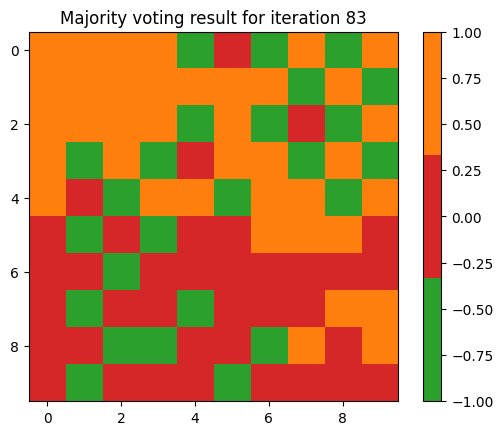

In [31]:
title = ('Majority voting result for iteration ' + str(83))
cmap1 = colors.ListedColormap([ 'tab:green','tab:red', 'tab:orange'])
plt.imshow(heart_map, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

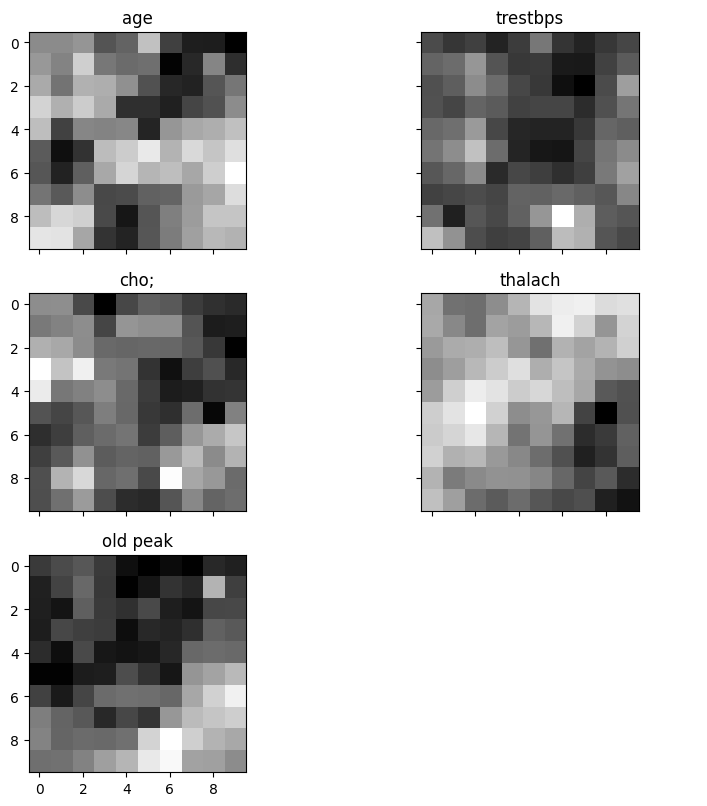

In [108]:
# Numerical


#a1 map
heart1_map = np.zeros(shape=(heart_x, heart_y))
for i in range(0,heart_x):
    for j in range(0,heart_y):
        heart1_map[i][j] = heart_weights[i][j][0]


#a2 map
heart2_map = np.zeros(shape=(heart_x, heart_y))
for i in range(0,heart_x):
    for j in range(0,heart_y):
        heart2_map[i][j] = heart_weights[i][j][1]

#a3 map
heart3_map = np.zeros(shape=(heart_x, heart_y))
for i in range(0,heart_x):
    for j in range(0,heart_y):
        heart3_map[i][j] = heart_weights[i][j][2]

#a4 map
heart4_map = np.zeros(shape=(heart_x, heart_y))
for i in range(0,heart_x):
    for j in range(0,heart_y):
        heart4_map[i][j] = heart_weights[i][j][3]

#a5 map
heart5_map = np.zeros(shape=(heart_x, heart_y))
for i in range(0,heart_x):
    for j in range(0,heart_y):
        heart5_map[i][j] = heart_weights[i][j][4]

#age	trestbps	chol	thalach	oldpeak	



cmap_gray = plt.cm.gray

fig_heart, axs_heart = plt.subplots(3, 2,figsize=(8,8))
fig_heart.tight_layout()

axs_heart[0, 0].imshow(heart1_map, cmap=cmap_gray)
axs_heart[0, 0].set_title('age')
axs_heart[0, 1].imshow(heart2_map, cmap=cmap_gray)
axs_heart[0, 1].set_title('trestbps')
axs_heart[1, 0].imshow(heart3_map, cmap=cmap_gray)
axs_heart[1, 0].set_title('cho;')
axs_heart[1, 1].imshow(heart4_map, cmap=cmap_gray)
axs_heart[1, 1].set_title('thalach')
axs_heart[2, 0].imshow(heart5_map, cmap=cmap_gray)
axs_heart[2, 0].set_title('old peak')

axs_heart[-1, -1].axis('off')

for ax in axs_heart.flat:
    ax.label_outer()


In [ ]:
# Categorical

_map =np.zeros(shape=(irish_x, irish_y), dtype= float)
for i in range(0,irish_x):
    for j in range(0,irish_y):
        m = max(irish_weights[i][j][4], key=irish_weights[i][j][4].get)
        if m == 'secondary':
            mm = 0
        elif m == 'primary_terminal_leaver':
            mm = 1
        elif m == 'vocational':
            mm = 2

        irish5_map[i][j] = mm


## Prostate Cancer Data

In [242]:
df_cancer = pd.read_csv('D:\\STATS4T06\\Datasets\\byar.csv')
df_cancer.iloc[:,13] = df_cancer.iloc[:,13].map({3:0, 4:1})


trainx_cancer = df_cancer.iloc[:,1:13]

trainy_cancer = df_cancer.iloc[:,13]


trainx_cancer


,Age,Weight,Systolic.Blood.pressure,Diastolic.blood.pressure,Serum.haemoglobin,Size.of.primary.tumour,Index.of.tumour.stage.and.histolic.grade,Serum.prostatic.acid.phosphatase,Performance.rating,Cardiovascular.disease.history,Electrocardiogram.code,Bone.metastases
0,75,76,15,9,138,2,8,3,0,0,4,0
1,69,102,14,8,134,3,9,3,0,1,4,0
2,75,94,14,7,176,4,8,9,1,1,1,0
3,67,99,17,10,134,34,8,5,0,0,0,0
4,71,98,19,10,151,10,11,6,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
470,73,100,19,10,168,2,11,29,0,1,0,0
471,78,108,11,6,158,9,13,6,0,0,0,0
472,78,127,16,10,158,5,9,5,0,1,4,0
473,77,93,17,10,160,11,9,8,0,0,3,0


In [217]:
df_cancer_x = 15
df_cancer_y = 15

cancer_map,cancer_re,cancer_weights,cancer_dis  = train_fmsom(x=df_cancer_x,y=df_cancer_y,data=trainx_cancer,y_label=trainy_cancer ,cr=8,s1=7,T=25,nei_fun = None,iteration=1000,seed = 10)



current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current iteration: 44
current iteration: 4

In [248]:
cancer_map

array([[ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  1],
       [ 1,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1],
       [ 0,  0,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1],
       [ 0,  1,  1,  1,  0,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1],
       [ 0,  0,  0,  0,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1],
       [ 0,  0,  0,  1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1],
       [ 1, -1,  1,  0, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1, -1],
       [ 1,  0,  1, -1, -1,  1,  0, -1,  1, -1,  1, -1, -1, -1,  1],
       [-1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1],
       [ 1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
       [ 1,  1, -1,  1, -1,  1,  1

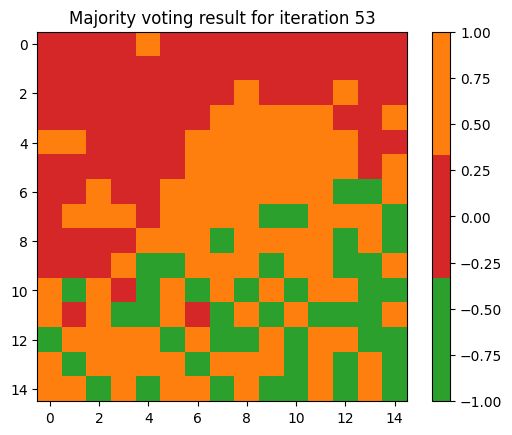

In [249]:
title = ('Majority voting result for iteration ' + str(53))
cmap1 = colors.ListedColormap([ 'tab:green','tab:red', 'tab:orange'])
plt.imshow(cancer_map, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

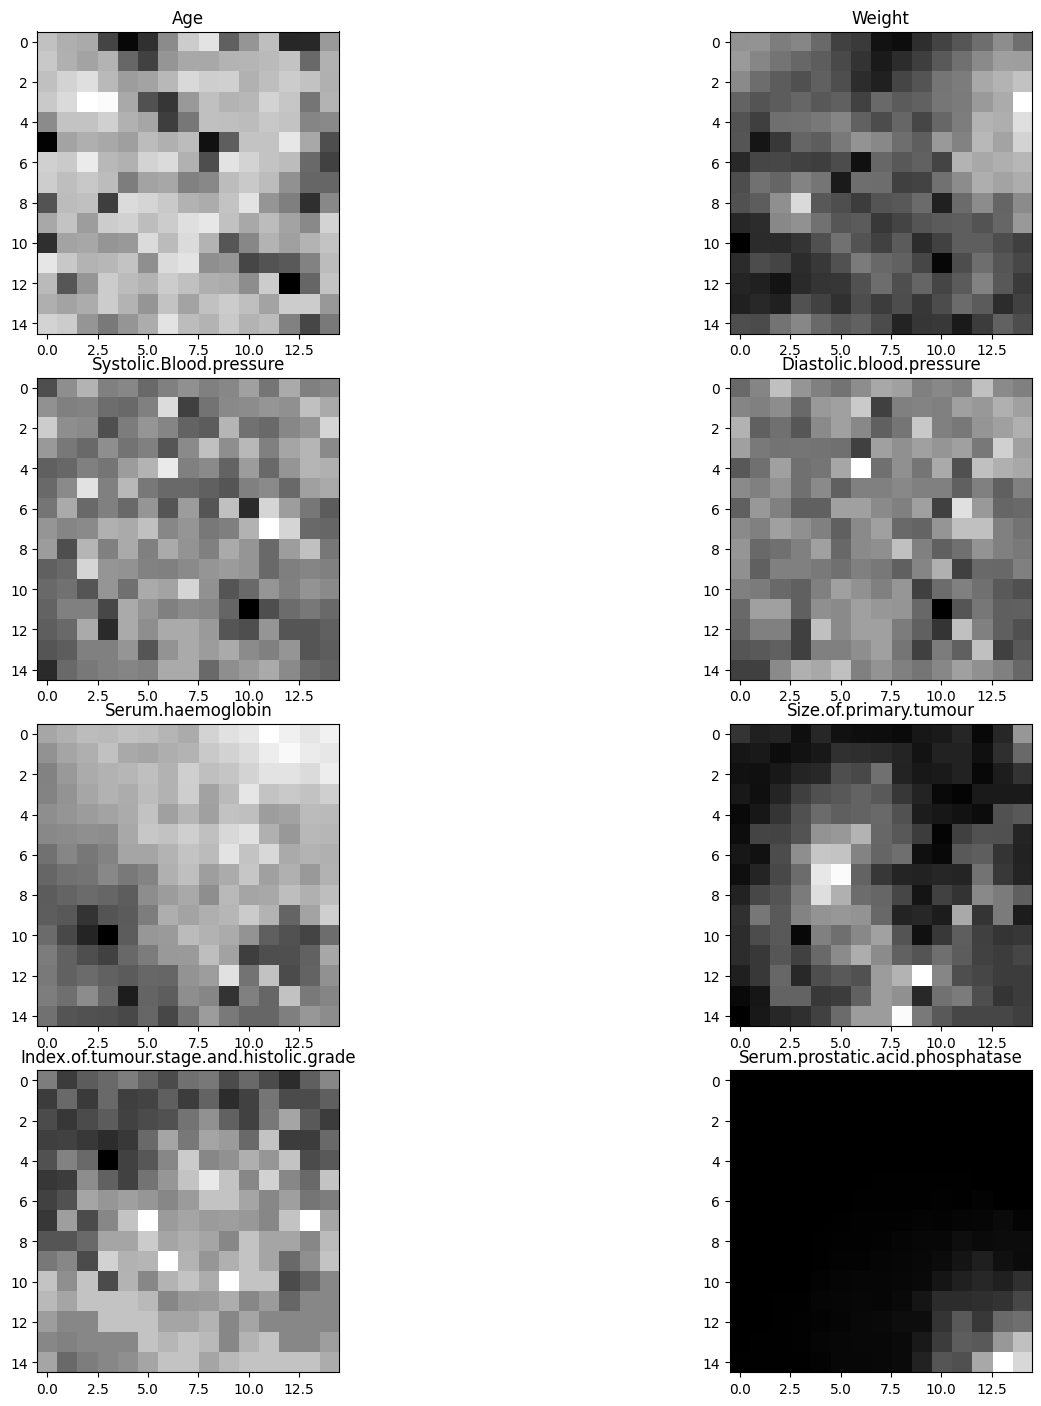

In [256]:
#numerical

#a1 map
cancer1_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer2_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer3_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer4_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer5_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer6_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer7_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer8_map = np.zeros(shape=(df_cancer_x, df_cancer_y))

for i in range(0,15):
    for j in range(0,15):
        cancer1_map[i][j] = cancer_weights[i][j][0]
        cancer2_map[i][j] = cancer_weights[i][j][1]
        cancer3_map[i][j] = cancer_weights[i][j][2]
        cancer4_map[i][j] = cancer_weights[i][j][3]
        cancer5_map[i][j] = cancer_weights[i][j][4]
        cancer6_map[i][j] = cancer_weights[i][j][5]
        cancer7_map[i][j] = cancer_weights[i][j][6]
        cancer8_map[i][j] = cancer_weights[i][j][7]



cmap_gray = plt.cm.gray

fig_cancer, axs_cancer = plt.subplots(4, 2,figsize=(14,14))
fig_cancer.tight_layout()

#Age	Weight	Systolic.Blood.pressure	Diastolic.blood.pressure	Serum.haemoglobin	Size.of.primary.tumour	Index.of.tumour.stage.and.histolic.grade	Serum.prostatic.acid.phosphatase	
axs_cancer[0, 0].imshow(cancer1_map, cmap=cmap_gray)
axs_cancer[0, 0].set_title('Age')
axs_cancer[0, 1].imshow(cancer2_map, cmap=cmap_gray)
axs_cancer[0, 1].set_title('Weight')
axs_cancer[1, 0].imshow(cancer3_map, cmap=cmap_gray)
axs_cancer[1, 0].set_title('Systolic.Blood.pressure')
axs_cancer[1, 1].imshow(cancer4_map, cmap=cmap_gray)
axs_cancer[1, 1].set_title('Diastolic.blood.pressure')
axs_cancer[2, 0].imshow(cancer5_map, cmap=cmap_gray)
axs_cancer[2, 0].set_title('Serum.haemoglobin')
axs_cancer[2, 1].imshow(cancer6_map, cmap=cmap_gray)
axs_cancer[2, 1].set_title('Size.of.primary.tumour')
axs_cancer[3, 0].imshow(cancer7_map, cmap=cmap_gray)
axs_cancer[3, 0].set_title('Index.of.tumour.stage.and.histolic.grade')
axs_cancer[3, 1].imshow(cancer8_map, cmap=cmap_gray)
axs_cancer[3, 1].set_title('Serum.prostatic.acid.phosphatase')


for ax in axs_heart.flat:
    ax.label_outer()




[0 1 2 3]
[0 1]
[4 1 0 5 2 3 6]
[0 1]


C:\Users\99506\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\99506\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


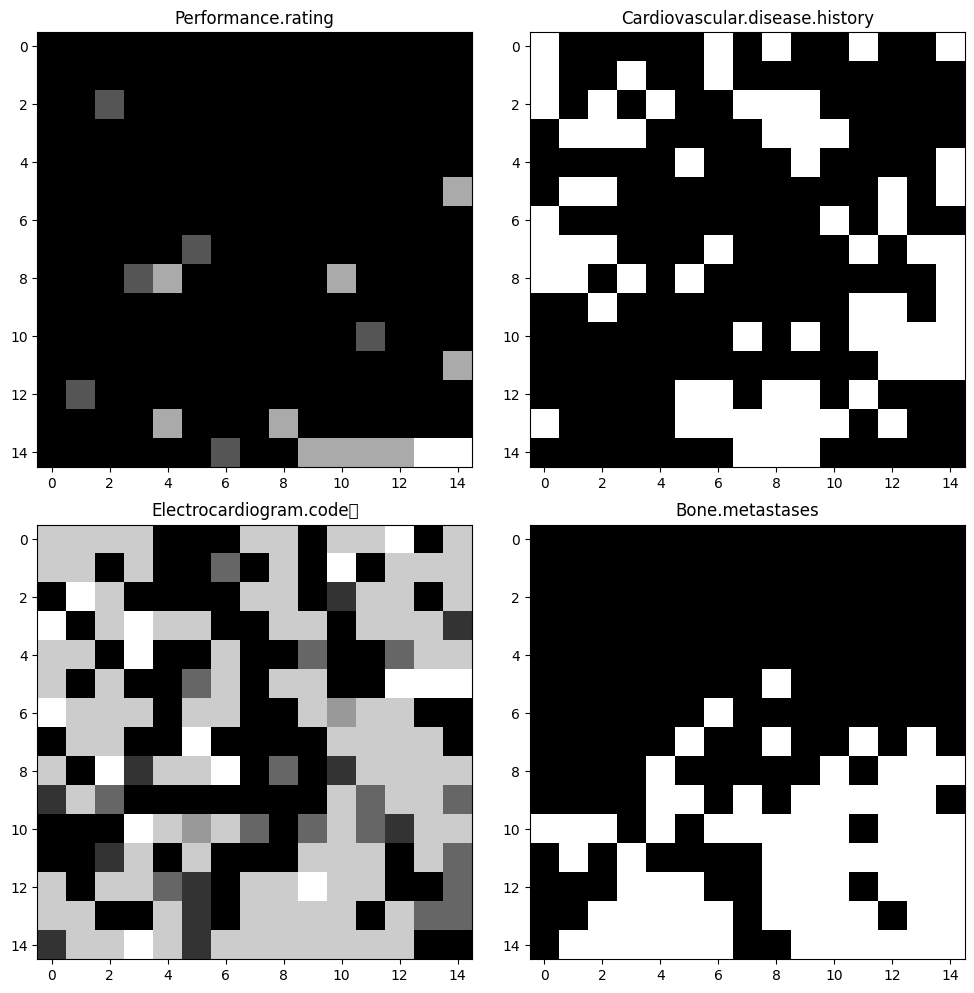

In [265]:
# cat
#Performance.rating	Cardiovascular.disease.history	Electrocardiogram.code	Bone.metastases

print(trainx_cancer.iloc[:,8].unique())
print(trainx_cancer.iloc[:,9].unique())
print(trainx_cancer.iloc[:,10].unique())
print(trainx_cancer.iloc[:,11].unique())

#cancer1_map = np.zeros(shape=(df_cancer_x, df_cancer_y))
cancer9_map =np.zeros(shape=(df_cancer_x, df_cancer_y), dtype= float)
for i in range(0,df_cancer_x):
    for j in range(0,df_cancer_y):
        m = max(cancer_weights[i][j][8], key=cancer_weights[i][j][8].get)
        
        cancer9_map[i][j] = m


cancer10_map =np.zeros(shape=(df_cancer_x, df_cancer_y), dtype= float)
for i in range(0,df_cancer_x):
    for j in range(0,df_cancer_y):
        m = max(cancer_weights[i][j][9], key=cancer_weights[i][j][9].get)

        cancer10_map[i][j] = m

cancer11_map =np.zeros(shape=(df_cancer_x, df_cancer_y), dtype= float)
for i in range(0,df_cancer_x):
    for j in range(0,df_cancer_y):
        m = max(cancer_weights[i][j][10], key=cancer_weights[i][j][10].get)

        cancer11_map[i][j] = m

cancer12_map =np.zeros(shape=(df_cancer_x, df_cancer_y), dtype= float)
for i in range(0,df_cancer_x):
    for j in range(0,df_cancer_y):
        m = max(cancer_weights[i][j][11], key=cancer_weights[i][j][11].get)

        cancer12_map[i][j] = m



cmap_gray = plt.cm.gray

fig_cancer, axs_cancer = plt.subplots(2, 2,figsize=(10,10))
fig_cancer.tight_layout()


axs_cancer[0, 0].imshow(cancer9_map, cmap=cmap_gray)
axs_cancer[0, 0].set_title('Performance.rating')
axs_cancer[0, 1].imshow(cancer10_map, cmap=cmap_gray)
axs_cancer[0, 1].set_title('Cardiovascular.disease.history')
axs_cancer[1, 0].imshow(cancer11_map, cmap=cmap_gray)
axs_cancer[1, 0].set_title('Electrocardiogram.code	')
axs_cancer[1, 1].imshow(cancer12_map, cmap=cmap_gray)
axs_cancer[1, 1].set_title('Bone.metastases')




for ax in axs_heart.flat:
    ax.label_outer()


## Sammon's Mapping

In [67]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

epoch = 1 : E = 0.0031907506
epoch = 2 : E = 0.0031431130
epoch = 3 : E = 0.0030354308
epoch = 4 : E = 0.0024931712
epoch = 5 : E = 0.0021559919
epoch = 6 : E = 0.0020358251
epoch = 7 : E = 0.0020127367
epoch = 8 : E = 0.0020095684
epoch = 9 : E = 0.0019986742
epoch = 10 : E = 0.0019910197
epoch = 11 : E = 0.0019866969
epoch = 12 : E = 0.0019840964
epoch = 13 : E = 0.0019827602
epoch = 14 : E = 0.0019819518
epoch = 15 : E = 0.0019814303
epoch = 16 : E = 0.0019810684
epoch = 17 : E = 0.0019808138
epoch = 18 : E = 0.0019806279
epoch = 19 : E = 0.0019804948
epoch = 20 : E = 0.0019803924
epoch = 21 : E = 0.0019803198
epoch = 22 : E = 0.0019802591
epoch = 23 : E = 0.0019802174
epoch = 24 : E = 0.0019801780
epoch = 25 : E = 0.0019801521
epoch = 26 : E = 0.0019801238
epoch = 27 : E = 0.0019801059
epoch = 28 : E = 0.0019800839
epoch = 29 : E = 0.0019800700
epoch = 30 : E = 0.0019800520
epoch = 31 : E = 0.0019800403
epoch = 32 : E = 0.0019800253
epoch = 33 : E = 0.0019800149
epoch = 34 : E = 0.

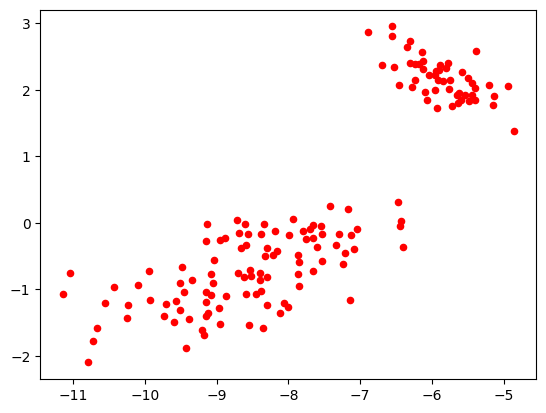

In [83]:
from sklearn import datasets
iris = datasets.load_iris()
(x,index) = np.unique(iris.data,axis=0,return_index=True)
[y,E] = sammon(x, 2)

plt.scatter(y[:,0], y[:,1], s=20, c='r', marker='o')



In [192]:
print(diag_weights)

def weightToProt(x,y,cr,W):

    prot = []
    for i in range(x):
        for j in range(y):
            l = []
            w = W[i][j]
            for k in range(0,cr):
                l.append(w[k])
            for h in range(cr,len(w)):
                l.append(max(w[h], key=w[h].get))
            
            prot.append(l)
    return prot



def weightToProt_mat(x,y,cr,W):

    prot = np.empty(shape=(x, y), dtype=object)
    for row in range(x):
        for col in range(y):
            prot[row][col] = [] # empty list to store the label
    for i in range(x):
        for j in range(y):
            
            w = W[i][j]
            for k in range(0,cr):
                prot[i][j].append(w[k])
            for h in range(cr,len(w)):
                prot[i][j].append(max(w[h], key=w[h].get))
            
            
    return prot


df_weights_diag = pd.DataFrame(weightToProt(10,10,1,diag_weights))

#df_weights_diag.to_csv('D:\\STATS4T06\\Datasets\\diag_weight.csv')


df_weights_prot_mat = weightToProt_mat(10,10,1,diag_weights)

print(df_weights_prot_mat)

[[[0.125, {'no': 1.0, 'yes': 0.0}, {'yes': 0.0, 'no': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}], [0.15661427525431984, {'no': 1.0, 'yes': 0.0}, {'yes': 0.0, 'no': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}], [0.22222222222222232, {'no': 1.0, 'yes': 0.0}, {'yes': 0.0, 'no': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}], [0.2999999999999998, {'no': 1.0, 'yes': 0.0}, {'yes': 0.0, 'no': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}], [0.34166666666666723, {'no': 1.0, 'yes': 0.0}, {'yes': 0.0, 'no': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}], [0.3916666666666666, {'no': 1.0, 'yes': 0.0}, {'yes': 0.0, 'no': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}, {'no': 0.0, 'yes': 1.0}], [0.5333333333333331, {'no': 0.6666666666666666, 'yes': 0.3333333333333333}, {'yes': 0.3333333333333333, 'no': 0.66666666666666

In [109]:
def findMax(x,y,Ai,Aj):
  dis = 0
  w = []
  wc = []
  
  indexX = [i for i, a in enumerate(Ai) if a == x]
  indexY = [i for i, a in enumerate(Ai) if a == y]
  
  ajX = [Aj[i] for i in indexX]
  ajY = [Aj[i] for i in indexY]
  
  uniAj = list(set(Aj))
  
  for i in range(len(uniAj)):
    indexU = [j for j, a in enumerate(Aj) if a == uniAj[i]]
    amountX = len([a for a in Ai[indexU] if a == x])
    amountY = len([a for a in Ai[indexU] if a == y])
    
    if len(indexX) == 0:
      pX = 0
    else:
      pX = amountX / len(indexX)
      
    if len(indexY) == 0:
      pY = 0
    else:
      pY = amountY / len(indexY)
    
    if pX >= pY:
      w.append(pX)
      dis += pX
    else:
      wc.append(pY)
      dis += pY
      
  dis -= 1
  
  return dis



def distance(x, y, i, df, cr):
    m, n = df.shape
    tol = 0
    
    for j in range(cr,n):
        if j == i:
            continue
        index_i = df.iloc[:, i]
        index_j = df.iloc[:, j]
        d_ij = findMax(x, y, index_i, index_j)
        tol += d_ij
    
    tol /= (n - 1)
    
    return tol


def sig(Ai, i, df):
    sum_ = 0
    s = pd.unique(Ai)
    m = len(s)
    
    for l in range(m-1):
        for j in range(l+1, m):
            tol = distance(s[l], s[j], i, df,0)
            sum_ += tol
    
    w = sum_ / (m*(m-1)/2)
    
    return w


def sigDf(discdf, cr):
    sigmas = []
  
    if cr != 0:
        for i in range(cr):
            sigmas.append(sig(discdf.iloc[:,i], i, discdf))
  
    return sigmas



#discretize

def discretize(df, cr):
    m, n = df.shape
    
    mat = np.zeros((m,n))
    discdf = pd.DataFrame(mat)
    
    if cr != 0:
        for i in range(cr):
            #discdf[i] = pd.cut(df.iloc[:,i], bins=10, labels=False, retbins=False)
            #discdf[i] = discdf[i].astype("category")
            discdf[i] = df.iloc[:,i].astype("str")
    
    catestart = cr 
    
    if catestart <= n:
        for j in range(catestart, n):
            discdf[j] = df.iloc[:,j]
    
    return discdf



def disBetTwo(d1, d2, cr, df, sigificance):
    length = len(d1)
    vrd1 = d1[0:cr]
    vcd1 = d2[cr:]
    vrd2 = d2[0:cr]
    vcd2 = d2[cr:]
    sumr = 0
    sumc = 0
    
    
    for i in range(0, cr):
        d = (sigificance[i]*(vrd1[i] - vrd2[i]))**2
        sumr += d
    
    for j in range(cr, length):
        d = distance(d1[j], d2[j], j, df,cr)
        
        sumc += d
    
    dis = sumr + sumc
    return dis


1
2
3
4


In [110]:
s = sigDf(df_weights_diag, 1)

s


[0.44086555207246025]

In [116]:
print(disBetTwo(df_weights_diag.loc[0], df_weights_diag.loc[1], 1, df_weights_diag, s))


dm = scipy.spatial.distance.cdist(df_weights_diag, df_weights_diag, lambda u, v: disBetTwo(u, v, 1, df_weights_diag, s))

0.002331467757759601


epoch = 1 : E = 13253.7581321284
epoch = 2 : E = 12085.6621053272
epoch = 3 : E = 11168.1800228947
epoch = 4 : E = 10395.0219792604
epoch = 5 : E = 9723.1453009346
epoch = 6 : E = 9128.6444321518
epoch = 7 : E = 8596.2811728335
epoch = 8 : E = 8115.4384562204
epoch = 9 : E = 7678.3770931375
epoch = 10 : E = 7279.1288329977
epoch = 11 : E = 6913.0311062707
epoch = 12 : E = 6576.2580954200
epoch = 13 : E = 6265.7063672323
epoch = 14 : E = 5978.6788024762
epoch = 15 : E = 5712.9560580515
epoch = 16 : E = 5466.5627055885
epoch = 17 : E = 5237.8045168451
epoch = 18 : E = 5025.2241229069
epoch = 19 : E = 4827.3633765623
epoch = 20 : E = 4643.0593794215
epoch = 21 : E = 4471.2322061656
epoch = 22 : E = 4310.8937944319
epoch = 23 : E = 4161.1403272017
epoch = 24 : E = 4021.1916994718
epoch = 25 : E = 3890.2546062872
epoch = 26 : E = 3767.6828674308
epoch = 27 : E = 3652.8366885859
epoch = 28 : E = 3545.1526886902
epoch = 29 : E = 3444.1023938681
epoch = 30 : E = 3349.2009961622
epoch = 31 : E 

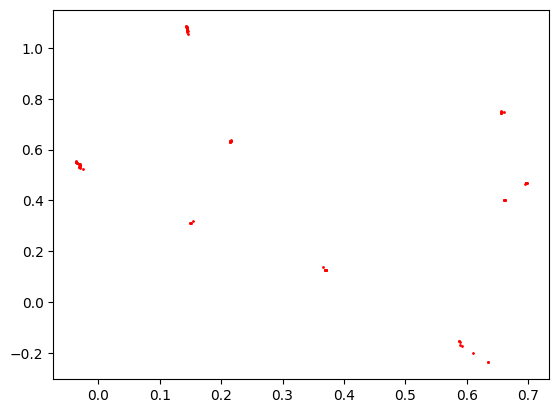

In [133]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = dm
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]



[y,E] = sammon(df_weights_diag, 2,maxiter= 600,init='random')

plt.scatter(y[:,0], y[:,1], s=1, c='r', marker='o')

In [205]:
# from sklearn.datasets import load_digits
# from sklearn.manifold import MDS

# embedding = MDS(n_components=2, normalized_stress='auto')
# X_transformed = embedding.fit(dm)



## U-matrix

In [201]:
def umatix(x,y,w,df,cr):
    # discretize
    sigificance = sigDf(df, cr)
    print("significance computed")

    mat = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            if (i == 0) and (j == 0):
                mat[i][j] = (disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/2
                continue
            elif (i == x-1) and (j == 0):
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/2
                continue
            elif (i == 0) and (j == y-1):
                mat[i][j] = (disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance))/2
                continue
            elif (i == x-1) and (j == y-1):
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance))/2
                continue
            elif i == 0:
                mat[i][j] = (disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance) + disBetTwo(w[i+1][j], w[i][j], cr, df, sigificance))/3
                continue
            elif i == x-1:
                mat[i][j] = (disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance) + disBetTwo(w[i-1][j], w[i][j], cr, df, sigificance))/3
                continue
            elif j == 0:
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/3
                continue
            elif j == y-1:
                mat[i][j] = (disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance))/3
                continue
            else:
                mat[i][j] = (disBetTwo(w[i][j], w[i+1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i-1][j], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j-1], cr, df, sigificance) + disBetTwo(w[i][j], w[i][j+1], cr, df, sigificance))/4
                continue
    return mat
                

In [202]:




u = umatix(10,10,df_weights_prot_mat,trainx_diag,1)



significance computed


array([[2.21270009e-04, 2.53668054e-04, 4.57260966e-04, 4.19983214e-04,
        1.78595507e-04, 1.18848445e-03, 5.88347071e-01, 2.94271600e-01,
        3.83132961e-04, 4.39095241e-04],
       [1.34805135e-01, 1.00715867e-01, 3.56372137e-04, 4.21666932e-04,
        4.36136571e-02, 2.65293190e-01, 4.42043601e-01, 4.53266564e-04,
        1.69109596e-01, 2.25104489e-01],
       [1.34439222e-01, 2.00662636e-01, 2.00198456e-01, 8.58093443e-02,
        8.59893739e-02, 2.21492181e-01, 3.09157709e-01, 3.37742462e-01,
        3.37848240e-01, 2.25889720e-01],
       [5.15790543e-03, 9.33785457e-04, 1.57559935e-01, 1.00075984e-01,
        1.19766521e-04, 3.24980787e-01, 3.41591633e-01, 2.18201959e-01,
        1.39038596e-03, 8.39798597e-04],
       [1.28615506e-01, 8.98329991e-02, 1.64791498e-01, 2.20704646e-01,
        3.26147327e-01, 3.27188373e-01, 4.52071187e-02, 4.55325001e-02,
        2.75638047e-01, 3.65508261e-01],
       [1.29687224e-01, 2.11955774e-01, 2.25875025e-01, 1.64216389e-01,
   

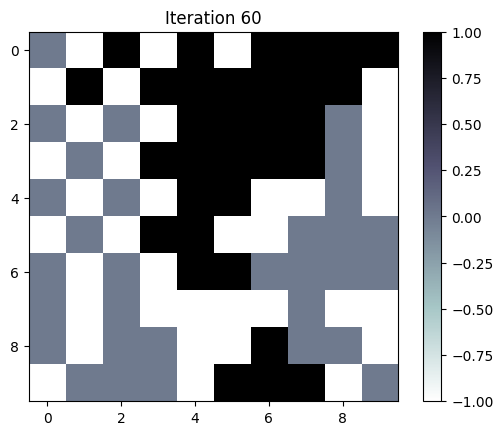

In [234]:
title = ('Iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
#plt.imshow(diag_map, cmap=cmap1)
plt.imshow(irish_map, cmap='bone_r')
plt.colorbar()
plt.title(title)
plt.show()

In [242]:
df_irish_prot_mat = weightToProt_mat(10,10,6,ca_weights1)
u = umatix(10,10,df_irish_prot_mat,trainx_ca,1)

KeyboardInterrupt: 

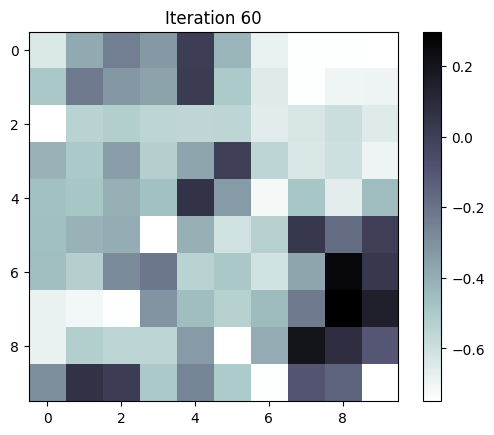

In [233]:
title = ('Iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
#plt.imshow(diag_map, cmap=cmap1)
plt.imshow(u, cmap='bone_r')
plt.colorbar()
plt.title(title)
plt.show()

In [255]:
seees = [1,111,35,999,1325,9989,5021,2141240,213,4155]
mse10 = []
cv10 = []
for i in seees:
  diag_map,diag_re,diag_weights,diag_dis,diag_mse = train_fmsom(x=10,y=10,data=trainx_diag,y_label=trainy1_diag ,cr=1,s1=2,T=10,nei_fun = None,iteration=1000,seed = i)
  mse10.append(diag_mse)
  cv10.append(cv(diag_re,1))

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current iteration: 22
current iteration: 23
current iteration: 24
current iteration: 25
current iteration: 26
current iteration: 27
current iteration: 28
current iteration: 29
current iteration: 30
current iteration: 31
current iteration: 32
current iteration: 33
current iteration: 34
current iteration: 35
current iteration: 36
current iteration: 37
current iteration: 38
current iteration: 39
current iteration: 40
current iteration: 41
current iteration: 42
current iteration: 43
current iteration: 44
current iteration: 4

significance computed


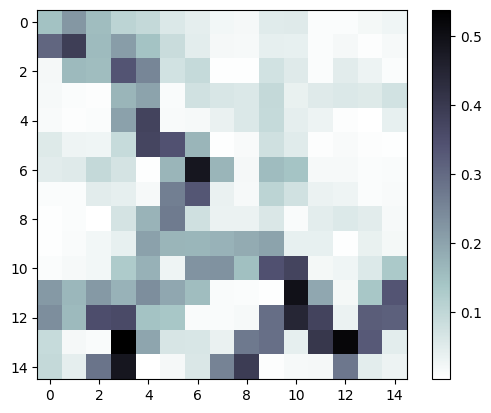

In [271]:
df_irish_prot_mat = weightToProt_mat(15,15,2,irish_weights)
u = umatix(15,15,df_irish_prot_mat,trainx_irish,2)
plt.style.use('default')
#title = ('Iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
#plt.imshow(diag_map, cmap=cmap1)
plt.imshow(u, cmap='bone_r')
plt.colorbar()
#plt.title(title)
plt.show()

## Cross validation 10-folds

In [354]:
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d","e","f","g","h","i","j","k","l","m"]

kf = KFold(n_splits=10)
iter = kf.split(trainx_diag)
while True:
    try:
        # 获得下一个值:
        i = next(iter)
        train_x = trainx_diag.iloc[i[0]]
        test_x =  trainx_diag.iloc[i[1]]
        train_y = trainy1_diag.iloc[i[0]]
        test_y =  trainy1_diag.iloc[i[1]] 
        print(i[0])

    except StopIteration:
        # 遇到StopIteration就退出循环
        break



# i = next(kf.split(trainy1_diag), None)
# train_x = trainx_diag.iloc[i[0]]
# test_x =  trainx_diag.iloc[i[1]]
# train_y = trainy1_diag.iloc[i[0]]
# test_y =  trainy1_diag.iloc[i[1]]


# print(train_y)
# print(test_y)

[ 12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119]
[  0   1   2   3   4   5   6   7   8   9  10  11  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  36  37  38  39  40  41 

In [380]:
def find_BMU(d1,weight,x,y,cr):
    bmu_x = 0
    bmu_y = 0
    bmu_dist = 10000000000
    for i in range(x):
        for j in range(y):
            d = dissimilarity(d1,weight[i][j],cr)            
            if d < bmu_dist:
                bmu_dist = d
                bmu_x = i 
                bmu_y = j
    return bmu_dist, bmu_x, bmu_y

In [463]:
kf = KFold(n_splits=10)
iter = kf.split(trainx_diag)
i = next(iter)

train_x = trainx_diag.iloc[i[0]]
test_x =  trainx_diag.iloc[i[1]]
train_y = trainy1_diag.iloc[i[0]]
test_y =  trainy1_diag.iloc[i[1]]

train_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

diag_map,diag_re,diag_weights,diag_dis,diag_mse = train_fmsom(x=10,y=10,data=train_x,y_label=train_y ,cr=1,s1=5,T=25,nei_fun = None,iteration=1000,seed = 1000)

truNum = 0
for j in range(len(test_x)):
    b_dist,b_x,b_y = find_BMU(test_x.loc[j],diag_weights,10,10,1)
    pred_class = diag_map[b_x,b_y]
    tru_class = test_y.loc[j]
    # print([b_x,b_y])
    # print(tru_class)
    if pred_class == tru_class:
        truNum += 1

print(truNum)
train_x

12


,Column1,Column2,Column3,Column4,Column5,Column6
0,0.183333,no,yes,no,no,no
1,0.200000,no,no,yes,yes,yes
2,0.200000,no,yes,no,no,no
3,0.200000,no,yes,no,no,no
4,0.216667,no,no,yes,yes,yes
...,...,...,...,...,...,...
103,0.983333,no,yes,yes,no,yes
104,1.000000,no,no,no,no,no
105,1.000000,yes,yes,no,yes,no
106,1.000000,no,yes,yes,no,yes


In [460]:
i = next(iter)

train_x = trainx_diag.iloc[i[0]]
test_x =  trainx_diag.iloc[i[1]]
train_y = trainy1_diag.iloc[i[0]]
test_y =  trainy1_diag.iloc[i[1]]

train_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

diag_map,diag_re,diag_weights,diag_dis,diag_mse = train_fmsom(x=10,y=10,data=train_x,y_label=train_y ,cr=1,s1=5,T=25,nei_fun = None,iteration=1000,seed = 1000)

truNum = 0
for j in range(len(test_x)):
    b_dist,b_x,b_y = find_BMU(test_x.loc[j],diag_weights,10,10,1)
    pred_class = diag_map[b_x,b_y]
    tru_class = test_y.loc[j]
    # print([b_x,b_y])
    # print(tru_class)
    if pred_class == tru_class:
        truNum += 1

print(truNum)


12


In [462]:
train_x

,Column1,Column2,Column3,Column4,Column5,Column6
0,0.000000,no,yes,no,no,no
1,0.066667,no,no,yes,yes,yes
2,0.066667,no,yes,no,no,no
3,0.083333,no,no,yes,yes,yes
4,0.083333,no,yes,no,no,no
...,...,...,...,...,...,...
103,0.983333,no,yes,yes,no,yes
104,1.000000,no,no,no,no,no
105,1.000000,yes,yes,no,yes,no
106,1.000000,no,yes,yes,no,yes


In [432]:
# print(test_x.loc[30])
# b_dist,b_x,b_y = find_BMU(test_x.loc[30],diag_weights,10,10,1)

# print(diag_map)
# print([b_x,b_y])
# print(diag_map[b_x,b_y])
# print(test_y.loc[30])

truNum = 0
for j in range(len(test_x)):
    b_dist,b_x,b_y = find_BMU(test_x.loc[j],diag_weights,10,10,1)
    pred_class = diag_map[b_x,b_y]
    tru_class = test_y.loc[j]
    # print([b_x,b_y])
    # print(tru_class)
    if pred_class == tru_class:
        truNum += 1

print(truNum)

0


In [498]:
from sklearn.metrics.cluster import adjusted_rand_score
def kfoldcrossAcc(trainx,trainy,x,y,cr,s1=5,T=25,seed = 1000, kfold=10):
    kf = KFold(n_splits=kfold)
    iter1 = kf.split(trainx)

    numCorrect= 0
    acc = []
    ari = []
    mse = []
    cvs = []
    while True:
        try:
            # 获得下一个值:
            i = next(iter1)
            #print("current train/test split" + str(i))
            train_x = trainx.iloc[i[0]]
            train_y = trainy.iloc[i[0]]
            test_x =  trainx.iloc[i[1]]         
            test_y =  trainy.iloc[i[1]] 
            #reset index
            train_x.reset_index(drop=True, inplace=True)
            test_x.reset_index(drop=True, inplace=True)
            train_y.reset_index(drop=True, inplace=True)
            test_y.reset_index(drop=True, inplace=True)

            #train model
            temp_map,temp_re,temp_weights,temp_dis,temp_mse = train_fmsom(x,
                                                                          y,
                                                                          data=train_x,
                                                                          y_label=train_y,
                                                                          cr=cr,
                                                                          s1=s1,
                                                                          T=T,
                                                                          nei_fun = None,
                                                                          iteration=1000,
                                                                          seed = seed)
            mse.append(temp_mse)
            cvs.append(cv(temp_re,cr))
            #ari:
            tru_class_set = list(test_y)
            pred_class_set = []
            #test accuracy for 
            numTru= 0 
            for j in range(len(test_x)):
                b_dist,b_x,b_y = find_BMU(test_x.loc[j],temp_weights,x,y,cr)
                pred_class = temp_map[b_x,b_y]
                tru_class = test_y.loc[j]

                pred_class_set.append(pred_class)

                if pred_class == tru_class:
                    

                    numTru = numTru + 1

            acc_ifold = numTru/len(test_x)
            ari_ifold = adjusted_rand_score(tru_class_set, pred_class_set)

            acc.append(acc_ifold)
            ari.append(ari_ifold)
            
        except StopIteration:
            break
    
    return [np.mean(acc),np.std(acc)], [np.mean(ari),np.std(ari)], np.mean(mse), np.mean(cvs)

In [507]:
# 8x8: [0.9333333333333332, 0.09718253158075502]
# 9x9: [0.9083333333333334, 0.11902380714238082]
# 10x10 [1.0, 0.0], [1.0, 0.0]
# 11x11 [0.8416666666666666, 0.19790570145063197]
# 12x12 [0.9, 0.13333333333333336], [0.8527236172938568, 0.19096387149416538]

kfoldcrossAcc(trainx_diag,trainy1_diag,10,10,1,s1=5,T=10,seed = 100, kfold=5)

([0.9833333333333332, 0.03333333333333335],
 [0.9537688442211056, 0.09246231155778893],
 0.058265211640211687,
 2.2430032951120964)

In [490]:
sizes = 10
radius = [2,3,4,5]
ts = [10,25,50]

[0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]

In [546]:
seees = [1,111,35,999,1325,9989,5021,2141240,213,4155]
mset = []
cvt = []
acct = []
arit = []
for i in seees:
  acc_temp, ari_temp, mse_temp, cv_temp = kfoldcrossAcc(trainx_diag,trainy1_diag,10,10,1,s1=5,T=50,seed = i, kfold=5)
  acct.append(acc_temp[0])
  arit.append(ari_temp[0])
  mset.append(mse_temp)
  cvt.append(cv_temp)

In [549]:
print(mset)
print(cvt)
print(acct)
print(arit)

[0.04636130952380954, 0.7594509182386477, 0.033844620811287626, 2.144499323505408, 0.024667063492063487, 0.03952023809523826, 0.030528747795414556, 0.01365185185185192, 0.022801234567901316, 0.05403069800569804]
[2.2459523248793456, 2.2395251658372515, 2.248884372749148, 2.225766145973127, 2.2499882703349927, 2.2457038437062655, 2.2500318515544686, 2.25349164276927, 2.2517862536782824, 2.246512555995242]
[0.9333333333333332, 0.95, 0.8666666666666666, 0.825, 1.0, 0.9333333333333332, 0.9583333333333333, 0.9583333333333333, 0.9416666666666668, 0.9083333333333332]
[0.9651221566975569, 0.9531117128333271, 0.8192283570269019, 0.7578287230359643, 1.0, 0.9651221566975569, 0.925767324121928, 0.925767324121928, 0.9074016723443791, 0.8663556562102268]


r = 2 T = 10

In [516]:
mse_2_10 = [0.02893326719576727,
 0.028275673400673502,
 0.01553888888888893,
 0.05100802469135797,
 0.09928370210036881,
 0.03494854497354505,
 0.04475694444444454,
 0.05127716049382719,
 0.05589616402116408,
 0.053264417989417945]
cv_2_10 =  [2.2493477728241253, 2.2482144520422427, 2.2525800059703514, 2.2439939539135847, 2.233763364951823, 2.247260146275214, 2.2442293538593865, 2.2447104650709138, 2.241628235907199, 2.240846096052883]

acc_2_10 = [0.9833333333333332, 0.8916666666666666, 0.9, 0.9083333333333332, 0.8916666666666666, 0.9416666666666668, 1.0, 0.875, 0.9416666666666667, 0.9166666666666667]
ari_2_10 = [0.9651221566975569, 0.8323006157755699, 0.8203279678355713, 0.925767324121928, 0.8671032080690029, 0.8824784142828743, 1.0, 0.8818858253673572, 0.9575786998264515, 0.9461903256402149]

r = 2 T = 25

In [517]:
mse_2_25 = [0.054751521164021356, 0.06156876441459798, 0.03101089065255739, 0.02551234567901231, 0.1220831128747795, 0.036547685185185266, 0.03430540123456805, 0.04354567901234567, 0.030996693121693196, 0.07569556893723574]
cv_2_25 = [2.2442415103583144, 2.244154052927154, 2.248500023955855, 2.2483911537034857, 2.2313059805449855, 2.2476255934539426, 2.2474385608855183, 2.243312461669187, 2.247404931911379, 2.238845225049785]
acc_2_25 = [0.9333333333333332, 0.925, 0.9583333333333333, 0.9166666666666666, 0.9416666666666667, 0.8833333333333332, 0.9833333333333332, 0.9083333333333332, 0.9583333333333333, 0.8833333333333334]
ari_2_25 = [0.8957754230292151, 0.8528071289107034, 0.9014102453402162, 0.8576930711204337, 0.8933658685374409, 0.8541418319374712, 0.9651221566975569, 0.8564205904535864, 0.9014102453402162, 0.957481081559499]

r = 2 T = 50

In [521]:
mse_2_50 = [0.0399372795414463, 0.04359305555555572, 0.028822222222222343, 0.025236507936507918, 0.10339984567901239, 0.020107341269841407, 0.05528570426487104, 0.05918218694885372, 0.05063536155202834, 0.06533978675645358]
cv_2_50 = [2.246942921723557, 2.245944852553694, 2.2508404390202172, 2.2501581428478614, 2.230109276677557, 2.2522738334991326, 2.2428207591066496, 2.24136559081477, 2.244159349205995, 2.2410718584549887]
acc_2_50 = [0.95, 0.9, 0.9333333333333333, 0.9833333333333332, 0.925, 0.9333333333333333, 0.8916666666666666, 0.9666666666666666, 0.9666666666666668, 0.9416666666666668]

ari_2_50 = [0.8871560550026416, 0.833168996466307, 0.9341798817759852, 0.9537688442211056, 0.8584880252349978, 0.9341798817759852, 0.8962432638439708, 0.9188910009186625, 0.9220338983050848, 0.957481081559499]





r = 3 T = 10

In [527]:
mse_3_10 = [0.0310889329805997, 0.0195380411255412, 0.037309810405643865, 0.05966327160493834, 0.035859638047138126, 0.018211772486772596, 0.019340123456790165, 0.044760487197987295, 0.03032824074074081, 0.02624259259259266]
cv_3_10 = [2.2484239642478085, 2.2516276681154808, 2.2450817693165215, 2.2435627057969034, 2.2470211802386926, 2.2518141104535134, 2.251543331701496, 2.2432805902127924, 2.2459423854315896, 2.249900441059824]
acc_3_10 = [0.9416666666666667, 0.95, 0.9333333333333332, 0.8666666666666668, 0.95, 0.8833333333333332, 0.9416666666666668, 0.9166666666666666, 0.925, 0.9333333333333332]
ari_3_10 = [0.9575786998264515, 0.9531117128333271, 0.8672498162720249, 0.7806089804022521, 0.90429107748939, 0.8515081901864446, 0.8915254237288135, 0.9003334243031906, 0.86993006993007, 0.8892268694550063]

r = 3 T = 25

In [530]:
mse_3_25 = [0.01738425925925926, 0.07472769976936648, 0.03556499118165794, 0.03070687830687833, 0.09388237934904611, 0.017342526455026562, 0.016001851851851916, 0.03781836419753087, 0.040349074074074204, 0.06744458689458699]
cv_3_25 = [2.251551996904656, 2.245464749388674, 2.248030373296756, 2.2489073140887412, 2.238479815121978, 2.253545133598523, 2.2541239431280053, 2.2459025698825705, 2.2446701014065122, 2.2433329182690516]
acc_3_25 = [0.925, 0.95, 0.9833333333333332, 0.9916666666666668, 0.9833333333333332, 0.95, 0.9, 0.9333333333333332, 0.9916666666666668, 1.0]
ari_3_25 = [0.9386468687691096, 0.9531117128333271, 0.9651221566975569, 0.9811296939097506, 0.9651221566975569, 0.9306532663316582, 0.8527236172938568, 0.8957754230292151, 0.9811296939097506, 1.0]

r = 3 T = 50

In [533]:
mse_3_50 = [0.020753439153439118, 0.01796613756613764, 0.020997530864197644, 0.04849521604938275, 0.08466390893057565, 0.02728002645502651, 0.030867636684303413, 0.04257594797178141, 0.027538275613275764, 0.02954351851851853]
cv_3_50 = [2.2501949569637345, 2.25285806419508, 2.251992579514691, 2.245637894571486, 2.2392324429926136, 2.2492858511891702, 2.2501583843381345, 2.247335045209055, 2.2500025149072123, 2.250462949378899]
acc_3_50 = [0.95, 0.9416666666666667, 0.975, 1.0, 1.0, 0.975, 0.95, 0.9333333333333332, 0.9333333333333332, 1.0]
ari_3_50 = [0.9531117128333271, 0.8941293375277357, 0.9348985381308562, 1.0, 1.0, 0.9362880886426593, 0.9531117128333271, 0.9619480685526234, 0.8620554127645874, 1.0]

r = 4 T = 10

In [536]:
mse_4_10 = [0.024607956549623305, 0.01637407407407419, 1.2430261684303365, 0.03395833333333341, 0.01875555555555563, 0.02038333333333353, 0.030590211640211695, 0.03305437710437707, 0.02118928571428579, 0.020884104938271666]
cv_4_10 = [2.2511895389528735, 2.252922497465749, 2.2197205514795924, 2.2479291711991705, 2.25173752587298, 2.2514992651113235, 2.247896589905126, 2.2488870865918122, 2.2495526671806565, 2.2515269876409576]
acc_4_10 = [0.9416666666666668, 0.9333333333333333, 0.925, 0.925, 0.95, 0.9, 0.9166666666666667, 0.875, 0.925, 0.9666666666666668]
ari_4_10 = [0.957481081559499, 0.91269031435926, 0.7860437162634619, 0.9137568802576983, 0.9362552278073781, 0.8306192327209487, 0.8768435919718733, 0.8101894346746918, 0.86993006993007, 0.9461903256402149]

r = 4 T =25

In [541]:
mse_4_25 = [0.05588964862298203, 0.020487037037037026, 0.0762432098765433, 0.05365785849952518, 0.01460185185185196, 0.058452977487291356, 0.027661419753086586, 0.04422539682539685, 0.039066997354497444, 0.027717989417989475]
cv_4_25 = [2.248281769903363, 2.2513992410326544, 2.2373909179219846, 2.2436926672982085, 2.252894990680667, 2.246136171458208, 2.2501249513842834, 2.2493267012979192, 2.246623644487074, 2.250190370177868]
acc_4_25 = [0.9166666666666666, 0.875, 0.9666666666666666, 0.9333333333333332, 0.9333333333333332, 0.9416666666666667, 0.9916666666666668, 0.9583333333333333, 0.9666666666666666, 0.8916666666666668]
ari_4_25 = [0.8716554483511987, 0.8374692399119466, 0.9188910009186625, 0.9651221566975569, 0.8620554127645874, 0.893655631277251, 0.9811296939097506, 0.925767324121928, 0.9188910009186625, 0.8676572873853935]

r = 4 T =50

In [542]:
mse_4_50 = [0.04125817901234573, 0.028747949735449772, 0.05539561287477969, 0.03251931216931223, 0.019273456790123395, 0.015925000000000106, 0.026473148148148253, 0.7733946482147203, 0.048372619047619164, 0.016081878306878357]
cv_4_50 = [2.247376402448782, 2.248401127307089, 2.241181710706546, 2.249094174082594, 2.250886925102806, 2.252397614000389, 2.2483783195756577, 2.2216487448420663, 2.243176510974817, 2.2518023188876954]
acc_4_50 = [0.925, 0.9666666666666668, 0.9833333333333332, 0.9833333333333332, 0.95, 0.95, 0.9666666666666668, 0.8083333333333332, 0.9583333333333333, 0.9666666666666666]
ari_4_50 = [0.9137568802576983, 0.9417721518987342, 0.9651221566975569, 0.9651221566975569, 0.8988015750727616, 0.9735862370386453, 0.9879895561357703, 0.7812877794300579, 0.9014102453402162, 0.9188910009186625]

r = 5 T = 10

In [547]:
mse_5_10 = [0.013908213083213111, 0.017256790123456867, 0.03528611111111119, 0.014355555555555583, 0.019271296296296314, 0.021246296296296423, 0.08485709876543227, 0.02332354497354499, 0.022016666666666757, 0.016631613756613706]
cv_5_10 = [2.25430808763342, 2.252384199242016, 2.245185273411921, 2.2525175602548915, 2.2506166549552855, 2.2504125778873143, 2.2391585576144473, 2.2495810812504233, 2.249792438119725, 2.2530921633952117]
acc_5_10 = [0.9333333333333332, 0.8916666666666666, 0.8583333333333332, 0.8333333333333333, 0.9083333333333334, 0.9166666666666667, 0.9916666666666668, 0.9416666666666668, 0.95, 0.8833333333333332]
ari_5_10 = [0.8620554127645874, 0.8407966850464736, 0.8080971670740569, 0.7958848305823583, 0.8675370017232336, 0.8893918021718591, 0.9811296939097506, 0.957481081559499, 1.0, 0.8820732618977173]

r = 5 T = 25

In [548]:
mse_5_25 = [0.01936300705467383, 0.05003935185185204, 0.036389197530864434, 0.03431922398589083, 0.04083734567901248, 0.01666064814814817, 0.031608333333333474, 0.01847051467051477, 0.03235524691358041, 0.026094179894180024]
cv_5_25 = [2.2525986119027506, 2.2444417972037014, 2.2484788591071543, 2.247241432541922, 2.2452028162245092, 2.2530413866584666, 2.2493387012054122, 2.2521872677669865, 2.2481635918347123, 2.2487578371972896]
acc_5_25 = [0.9333333333333332, 0.8833333333333332, 0.9083333333333332, 0.9083333333333332, 0.9666666666666666, 0.9583333333333333, 0.975, 0.9, 0.8666666666666668, 0.8583333333333332]
ari_5_25 = [0.9126950653732603, 0.9300675675675676, 0.925767324121928, 0.8733842649596651, 0.9188910009186625, 0.925767324121928, 0.9362880886426593, 0.8495442672503207, 0.8943431085761107, 0.9259547606522883]

r = 5 T =50

In [550]:
mse_5_50 = [0.04636130952380954, 0.7594509182386477, 0.033844620811287626, 2.144499323505408, 0.024667063492063487, 0.03952023809523826, 0.030528747795414556, 0.01365185185185192, 0.022801234567901316, 0.05403069800569804]
cv_5_50 = [2.2459523248793456, 2.2395251658372515, 2.248884372749148, 2.225766145973127, 2.2499882703349927, 2.2457038437062655, 2.2500318515544686, 2.25349164276927, 2.2517862536782824, 2.246512555995242]
acc_5_50 = [0.9333333333333332, 0.95, 0.8666666666666666, 0.825, 1.0, 0.9333333333333332, 0.9583333333333333, 0.9583333333333333, 0.9416666666666668, 0.9083333333333332]
ari_5_50 = [0.9651221566975569, 0.9531117128333271, 0.8192283570269019, 0.7578287230359643, 1.0, 0.9651221566975569, 0.925767324121928, 0.925767324121928, 0.9074016723443791, 0.8663556562102268]

## Parameter Selection Plot

C:\Users\99506\AppData\Local\Temp\ipykernel_18852\276823257.py:335: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


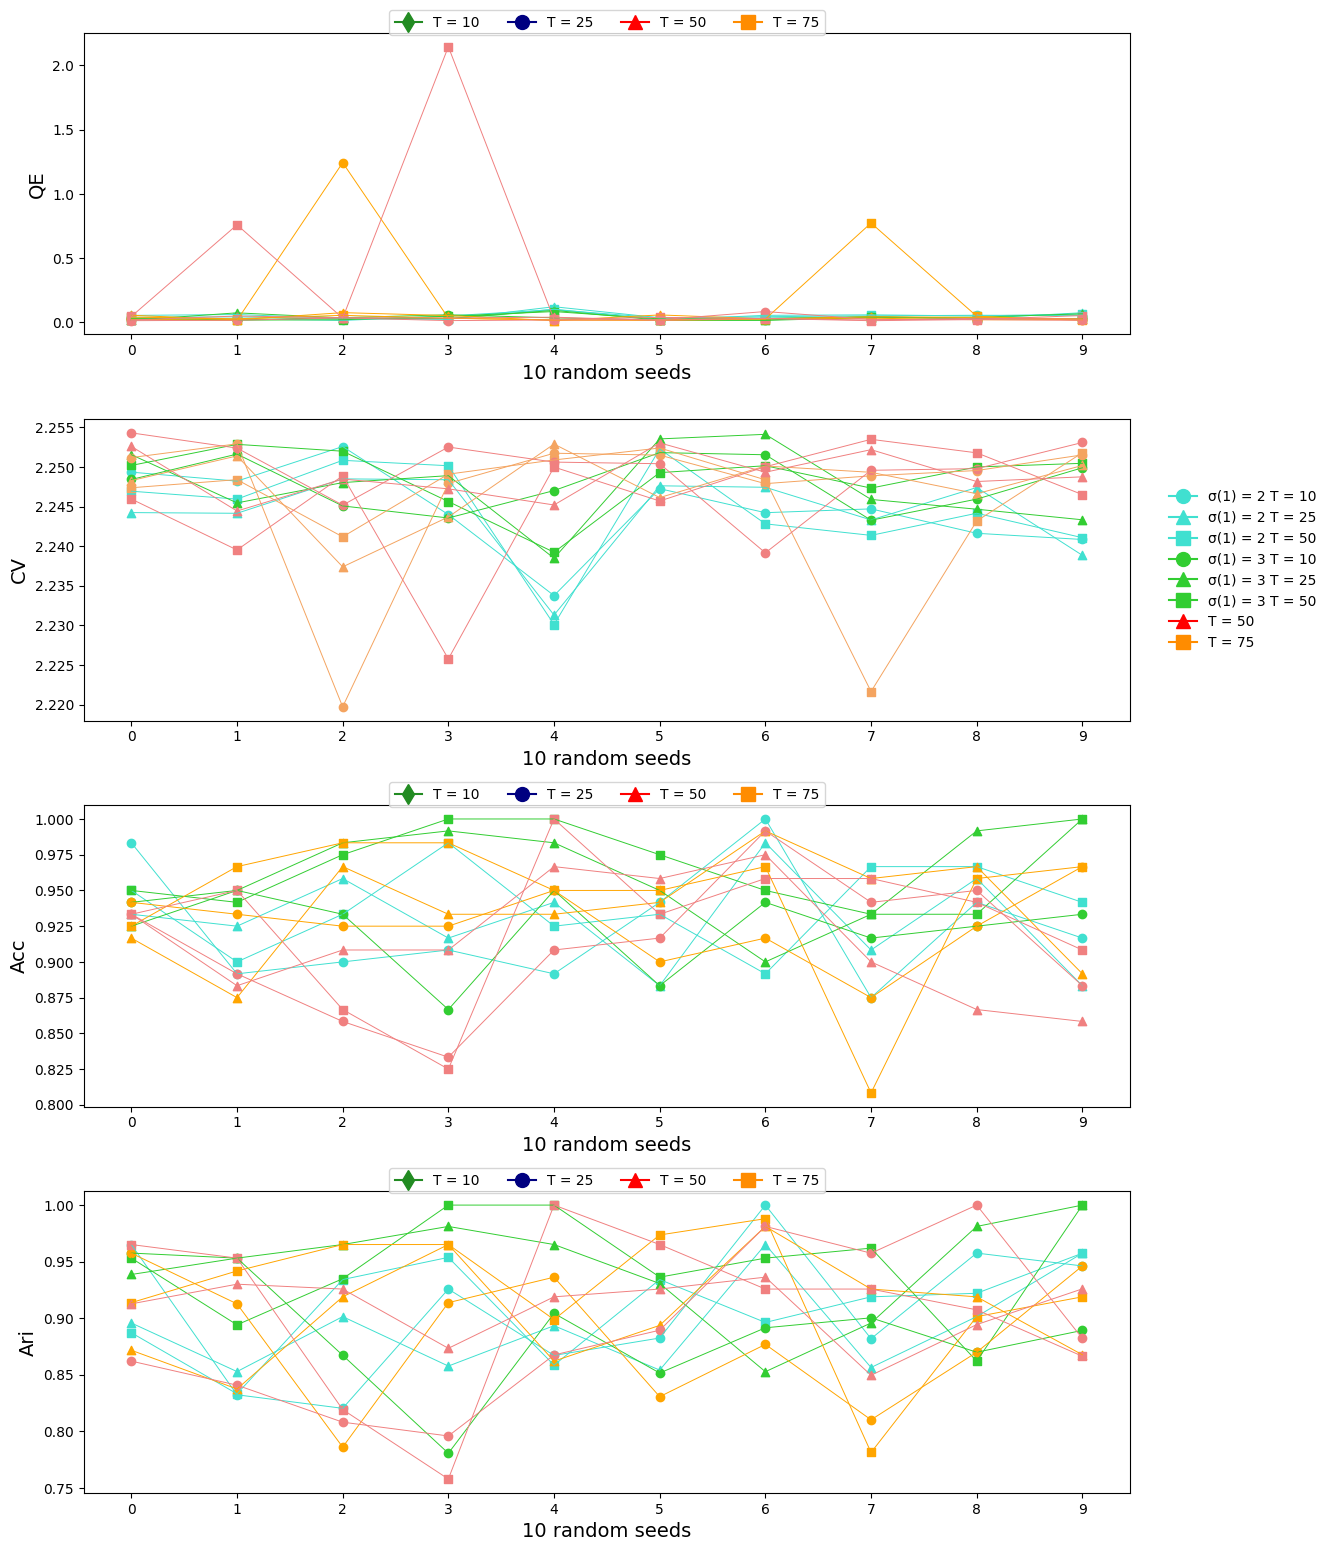

In [588]:
from matplotlib.pyplot import MultipleLocator
import matplotlib.lines as mlines
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(12,16))
fig.tight_layout(pad=4)

Ts = [0,1,2,3,4,5,6,7,8,9]

#fig = plt.figure(figsize=(12,4))

#radius 2
axs[0].scatter(Ts,mse_2_10,marker = 'o',c= 'turquoise',label = 'T = 25')
axs[0].plot(Ts,mse_2_10,c= 'turquoise',linewidth=0.7)
axs[0].scatter(Ts,mse_2_25,marker = '^',c= 'turquoise')
axs[0].plot(Ts,mse_2_25,c= 'turquoise',linewidth=0.7)
axs[0].scatter(Ts,mse_2_50,marker = 's',c= 'turquoise')
axs[0].plot(Ts,mse_2_50,c= 'turquoise',linewidth=0.7)

#radius 3
axs[0].scatter(Ts,mse_3_10,marker = 'o',c= 'limegreen',label = 'T = 25')
axs[0].plot(Ts,mse_3_10,c= 'limegreen',linewidth=0.7)
axs[0].scatter(Ts,mse_3_25,marker = '^',c= 'limegreen')
axs[0].plot(Ts,mse_3_25,c= 'limegreen',linewidth=0.7)
axs[0].scatter(Ts,mse_3_50,marker = 's',c= 'limegreen')
axs[0].plot(Ts,mse_3_50,c= 'limegreen',linewidth=0.7)

#radius 4
axs[0].scatter(Ts,mse_4_10,marker = 'o',c= 'orange',label = 'T = 25')
axs[0].plot(Ts,mse_4_10,c= 'orange',linewidth=0.7)
axs[0].scatter(Ts,mse_4_25,marker = '^',c= 'orange')
axs[0].plot(Ts,mse_4_25,c= 'orange',linewidth=0.7)
axs[0].scatter(Ts,mse_4_50,marker = 's',c= 'orange')
axs[0].plot(Ts,mse_4_50,c= 'orange',linewidth=0.7)


#radius 5
axs[0].scatter(Ts,mse_5_10,marker = 'o',c= 'lightcoral',label = 'T = 25')
axs[0].plot(Ts,mse_5_10,c= 'lightcoral',linewidth=0.7)
axs[0].scatter(Ts,mse_5_25,marker = '^',c= 'lightcoral')
axs[0].plot(Ts,mse_5_25,c= 'lightcoral',linewidth=0.7)
axs[0].scatter(Ts,mse_5_50,marker = 's',c= 'lightcoral')
axs[0].plot(Ts,mse_5_50,c= 'lightcoral',linewidth=0.7)

# axs[0].scatter(Ts,mse100,marker = 'd',c= 'forestgreen')
# axs[0].plot(Ts,mse100,c= 'forestgreen',linewidth=0.7)

green_line = mlines.Line2D([], [], color='forestgreen', marker='d',
                          markersize=10, label='T = 10')
blue_line = mlines.Line2D([], [], color='navy', marker='o',
                          markersize=10, label='T = 25')

red_line = mlines.Line2D([], [], color='red', marker='^',
                          markersize=10, label='T = 50')
orange_line = mlines.Line2D([], [], color='darkorange', marker='s',
                          markersize=10, label='T = 75')

#plt.legend(handles=[green_line,blue_line,red_line,orange_line])



x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里

#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
axs[0].xaxis.set_major_locator(x_major_locator)
axs[0].set_xlabel('10 random seeds',fontsize=14)

axs[0].set_ylabel('QE',fontsize=14)

pos = axs[0].get_position()

axs[0].legend(
    handles=[green_line,blue_line,red_line,orange_line],
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1),
    ncol=4, 
     
)








#radius 2
axs[1].scatter(Ts,cv_2_10,marker = 'o',c= 'turquoise',label = 'T = 25')
axs[1].plot(Ts,cv_2_10,c= 'turquoise',linewidth=0.7)
axs[1].scatter(Ts,cv_2_25,marker = '^',c= 'turquoise')
axs[1].plot(Ts,cv_2_25,c= 'turquoise',linewidth=0.7)
axs[1].scatter(Ts,cv_2_50,marker = 's',c= 'turquoise')
axs[1].plot(Ts,cv_2_50,c= 'turquoise',linewidth=0.7)

#radius 3
axs[1].scatter(Ts,cv_3_10,marker = 'o',c= 'limegreen',label = 'T = 25')
axs[1].plot(Ts,cv_3_10,c= 'limegreen',linewidth=0.7)
axs[1].scatter(Ts,cv_3_25,marker = '^',c= 'limegreen')
axs[1].plot(Ts,cv_3_25,c= 'limegreen',linewidth=0.7)
axs[1].scatter(Ts,cv_3_50,marker = 's',c= 'limegreen')
axs[1].plot(Ts,cv_3_50,c= 'limegreen',linewidth=0.7)

#radius 4
axs[1].scatter(Ts,cv_4_10,marker = 'o',c= 'sandybrown',label = 'T = 25')
axs[1].plot(Ts,cv_4_10,c= 'sandybrown',linewidth=0.7)
axs[1].scatter(Ts,cv_4_25,marker = '^',c= 'sandybrown')
axs[1].plot(Ts,cv_4_25,c= 'sandybrown',linewidth=0.7)
axs[1].scatter(Ts,cv_4_50,marker = 's',c= 'sandybrown')
axs[1].plot(Ts,cv_4_50,c= 'sandybrown',linewidth=0.7)


#radius 5
axs[1].scatter(Ts,cv_5_10,marker = 'o',c= 'lightcoral',label = 'T = 25')
axs[1].plot(Ts,cv_5_10,c= 'lightcoral',linewidth=0.7)
axs[1].scatter(Ts,cv_5_25,marker = '^',c= 'lightcoral')
axs[1].plot(Ts,cv_5_25,c= 'lightcoral',linewidth=0.7)
axs[1].scatter(Ts,cv_5_50,marker = 's',c= 'lightcoral')
axs[1].plot(Ts,cv_5_50,c= 'lightcoral',linewidth=0.7)

turquoise_line_10 = mlines.Line2D([], [], color='turquoise', marker='o',
                          markersize=10, label='\u03C3(1) = 2 T = 10')
turquoise_line_25 = mlines.Line2D([], [], color='turquoise', marker='^',
                          markersize=10, label='\u03C3(1) = 2 T = 25')
turquoise_line_50 = mlines.Line2D([], [], color='turquoise', marker='s',
                          markersize=10, label='\u03C3(1) = 2 T = 50')

limegreen_line_10 = mlines.Line2D([], [], color='limegreen', marker='o',
                          markersize=10, label='\u03C3(1) = 3 T = 10')
limegreen_line_25 = mlines.Line2D([], [], color='limegreen', marker='^',
                          markersize=10, label='\u03C3(1) = 3 T = 25')
limegreen_line_50 = mlines.Line2D([], [], color='limegreen', marker='s',
                          markersize=10, label='\u03C3(1) = 3 T = 50')

limegreen_line_10 = mlines.Line2D([], [], color='limegreen', marker='o',
                          markersize=10, label='\u03C3(1) = 3 T = 10')
limegreen_line_25 = mlines.Line2D([], [], color='limegreen', marker='^',
                          markersize=10, label='\u03C3(1) = 3 T = 25')
limegreen_line_50 = mlines.Line2D([], [], color='limegreen', marker='s',
                          markersize=10, label='\u03C3(1) = 3 T = 50')

red_line = mlines.Line2D([], [], color='red', marker='^',
                          markersize=10, label='T = 50')
orange_line = mlines.Line2D([], [], color='darkorange', marker='s',
                          markersize=10, label='T = 75')

#plt.legend(handles=[green_line,blue_line,red_line,orange_line])



x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里

#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
axs[1].xaxis.set_major_locator(x_major_locator)
axs[1].set_xlabel('10 random seeds',fontsize=14)

axs[1].set_ylabel('CV',fontsize=14)

pos = axs[1].get_position()

# ax[1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
# ax[1].legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

axs[1].legend(
    handles=[turquoise_line_10,turquoise_line_25, turquoise_line_50, 
             limegreen_line_10, limegreen_line_25, limegreen_line_50, 
             red_line,orange_line],
    loc='center right', 
    bbox_to_anchor=(1.19, 0.5),
    frameon=False
     
)







#radius 2
axs[2].scatter(Ts,acc_2_10,marker = 'o',c= 'turquoise',label = 'T = 25')
axs[2].plot(Ts,acc_2_10,c= 'turquoise',linewidth=0.7)
axs[2].scatter(Ts,acc_2_25,marker = '^',c= 'turquoise')
axs[2].plot(Ts,acc_2_25,c= 'turquoise',linewidth=0.7)
axs[2].scatter(Ts,acc_2_50,marker = 's',c= 'turquoise')
axs[2].plot(Ts,acc_2_50,c= 'turquoise',linewidth=0.7)

#radius 3
axs[2].scatter(Ts,acc_3_10,marker = 'o',c= 'limegreen',label = 'T = 25')
axs[2].plot(Ts,acc_3_10,c= 'limegreen',linewidth=0.7)
axs[2].scatter(Ts,acc_3_25,marker = '^',c= 'limegreen')
axs[2].plot(Ts,acc_3_25,c= 'limegreen',linewidth=0.7)
axs[2].scatter(Ts,acc_3_50,marker = 's',c= 'limegreen')
axs[2].plot(Ts,acc_3_50,c= 'limegreen',linewidth=0.7)

#radius 4
axs[2].scatter(Ts,acc_4_10,marker = 'o',c= 'orange',label = 'T = 25')
axs[2].plot(Ts,acc_4_10,c= 'orange',linewidth=0.7)
axs[2].scatter(Ts,acc_4_25,marker = '^',c= 'orange')
axs[2].plot(Ts,acc_4_25,c= 'orange',linewidth=0.7)
axs[2].scatter(Ts,acc_4_50,marker = 's',c= 'orange')
axs[2].plot(Ts,acc_4_50,c= 'orange',linewidth=0.7)


#radius 5
axs[2].scatter(Ts,acc_5_10,marker = 'o',c= 'lightcoral',label = 'T = 25')
axs[2].plot(Ts,acc_5_10,c= 'lightcoral',linewidth=0.7)
axs[2].scatter(Ts,acc_5_25,marker = '^',c= 'lightcoral')
axs[2].plot(Ts,acc_5_25,c= 'lightcoral',linewidth=0.7)
axs[2].scatter(Ts,acc_5_50,marker = 's',c= 'lightcoral')
axs[2].plot(Ts,acc_5_50,c= 'lightcoral',linewidth=0.7)

green_line = mlines.Line2D([], [], color='forestgreen', marker='d',
                          markersize=10, label='T = 10')
blue_line = mlines.Line2D([], [], color='navy', marker='o',
                          markersize=10, label='T = 25')

red_line = mlines.Line2D([], [], color='red', marker='^',
                          markersize=10, label='T = 50')
orange_line = mlines.Line2D([], [], color='darkorange', marker='s',
                          markersize=10, label='T = 75')

#plt.legend(handles=[green_line,blue_line,red_line,orange_line])



x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里

#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
axs[2].xaxis.set_major_locator(x_major_locator)
axs[2].set_xlabel('10 random seeds',fontsize=14)

axs[2].set_ylabel('Acc',fontsize=14)

pos = axs[2].get_position()

axs[2].legend(
    handles=[green_line,blue_line,red_line,orange_line],
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1),
    ncol=4, 
     
)






#radius 2
axs[3].scatter(Ts,ari_2_10,marker = 'o',c= 'turquoise',label = 'T = 25')
axs[3].plot(Ts,ari_2_10,c= 'turquoise',linewidth=0.7)
axs[3].scatter(Ts,ari_2_25,marker = '^',c= 'turquoise')
axs[3].plot(Ts,ari_2_25,c= 'turquoise',linewidth=0.7)
axs[3].scatter(Ts,ari_2_50,marker = 's',c= 'turquoise')
axs[3].plot(Ts,ari_2_50,c= 'turquoise',linewidth=0.7)

#radius 3
axs[3].scatter(Ts,ari_3_10,marker = 'o',c= 'limegreen',label = 'T = 25')
axs[3].plot(Ts,ari_3_10,c= 'limegreen',linewidth=0.7)
axs[3].scatter(Ts,ari_3_25,marker = '^',c= 'limegreen')
axs[3].plot(Ts,ari_3_25,c= 'limegreen',linewidth=0.7)
axs[3].scatter(Ts,ari_3_50,marker = 's',c= 'limegreen')
axs[3].plot(Ts,ari_3_50,c= 'limegreen',linewidth=0.7)

#radius 4
axs[3].scatter(Ts,ari_4_10,marker = 'o',c= 'orange',label = 'T = 25')
axs[3].plot(Ts,ari_4_10,c= 'orange',linewidth=0.7)
axs[3].scatter(Ts,ari_4_25,marker = '^',c= 'orange')
axs[3].plot(Ts,ari_4_25,c= 'orange',linewidth=0.7)
axs[3].scatter(Ts,ari_4_50,marker = 's',c= 'orange')
axs[3].plot(Ts,ari_4_50,c= 'orange',linewidth=0.7)


#radius 5
axs[3].scatter(Ts,ari_5_10,marker = 'o',c= 'lightcoral',label = 'T = 25')
axs[3].plot(Ts,ari_5_10,c= 'lightcoral',linewidth=0.7)
axs[3].scatter(Ts,ari_5_25,marker = '^',c= 'lightcoral')
axs[3].plot(Ts,ari_5_25,c= 'lightcoral',linewidth=0.7)
axs[3].scatter(Ts,ari_5_50,marker = 's',c= 'lightcoral')
axs[3].plot(Ts,ari_5_50,c= 'lightcoral',linewidth=0.7)

green_line = mlines.Line2D([], [], color='forestgreen', marker='d',
                          markersize=10, label='T = 10')
blue_line = mlines.Line2D([], [], color='navy', marker='o',
                          markersize=10, label='T = 25')

red_line = mlines.Line2D([], [], color='red', marker='^',
                          markersize=10, label='T = 50')
orange_line = mlines.Line2D([], [], color='darkorange', marker='s',
                          markersize=10, label='T = 75')

#plt.legend(handles=[green_line,blue_line,red_line,orange_line])



x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里

#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
axs[3].xaxis.set_major_locator(x_major_locator)
axs[3].set_xlabel('10 random seeds',fontsize=14)

axs[3].set_ylabel('Ari',fontsize=14)

pos = axs[3].get_position()

axs[3].legend(
    handles=[green_line,blue_line,red_line,orange_line],
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1),
    ncol=4, 
     
)











# fig.savefig('T_ai1.png',dpi=600, bbox_inches='tight')
fig.show()